In [1]:
import sys
import numpy as np
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
from vampires_calibration.csv_tools import read_csv,match_fits_tags
from vampires_calibration.on_sky import write_fits_info_to_csv_psf,fit_CHARIS_Mueller_matrix_by_bin_m3
import matplotlib as plt
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    "lines.linewidth": 3,
})
from matplotlib.ticker import MultipleLocator
from vampires_calibration.utils import process_errors,generate_system_mueller_matrix,process_dataset,process_model
from vampires_calibration.fitting import model
from vampires_calibration.plotting import plot_data_and_model
from vampires_calibration.constants import wavelength_bins
from pyMuellerMat.physical_models.charis_physical_models import HWP_retardance, IMR_retardance,M3_diattenuation,M3_retardance



/opt/anaconda3/envs/charisenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# I had to manually change the names of the cubes to match the IDs on my raw files so my csv writer works
cubedir = '/Users/thomasmcintosh/Desktop/CHARIS-REU/testing_model/BD343631/cubes'
rawdir = '/Users/thomasmcintosh/Desktop/CHARIS-REU/testing_model/BD343631/raw' # pre DEP fits
centroid_guesses = ([65,83],[133,118]) # guesses for PSF centroids
annuli_radii = ([15,25],[15,25]) # annuli for background subtraction
aper_radii = (15,15) # using ~3X FWHM for aperture radius
box_size = 45 # box for centroid finder to search
hwp_order = [0,45,22.5,67.5] # use this order for double diff Stokes Q and U
for bin in range(0,22): # iterate through all wavelength bins
    csv_out = f'/Users/thomasmcintosh/Desktop/CHARIS-REU/testing_model/BD343631/csvs/bin{bin}.csv'
    write_fits_info_to_csv_psf(cubedir,rawdir,csv_out,
                               centroid_guesses,aper_radii,box_size,bin,
                               bkgd_annuli_radii=annuli_radii,
                               plot=True,hwp_order=hwp_order) # plot to check centroids/apertures


In [2]:
# Plotting data with original model

filepath = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/testing_model/BD343631/csvs/bin4.csv')

# Read in data

interleaved_values, interleaved_stds, configuration_list = read_csv(filepath,mode='m3')
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values[0 : 10])
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list[0 : 10])
print(interleaved_stds[0])

Interleaved Values
Length:  16
[  5048.61840607 179304.38450099   6891.71932663 186973.00795062
   3818.69218047 179834.53584193   7617.45042424 174256.8746022
   5136.85028889 174995.08972068]
Interleaved Stds
Length:  16
[432.99440122 432.99440122 468.32872628 468.32872628 446.32372944
 446.32372944 422.24666243 422.24666243 408.14944837 408.14944837]
Configuration List
Length:  8
[{'hwp': {'theta': 67.5}, 'image_rotator': {'theta': 97.25913}, 'altitude_rot': {'pa': 65.50953458}, 'parang_rot': {'pa': 123.46673480239}}, {'hwp': {'theta': 22.5}, 'image_rotator': {'theta': 97.34929}, 'altitude_rot': {'pa': 65.69393151}, 'parang_rot': {'pa': 123.8937832315757}}, {'hwp': {'theta': 45.0}, 'image_rotator': {'theta': 97.43921}, 'altitude_rot': {'pa': 65.87713501}, 'parang_rot': {'pa': 124.3265538099569}}, {'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 97.53779}, 'altitude_rot': {'pa': 66.05939067}, 'parang_rot': {'pa': 124.7656254339029}}, {'hwp': {'theta': 67.5}, 'image_rotator': {'thet

In [4]:

# Loading in past fits 

offset_imr = 0.13214 # derotator offset
offset_hwp = -0.99287 # HWP offset
offset_cal = 0.49797 # calibration polarizer offset
imr_theta = 0
hwp_theta = 0

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "altitude_rot" : {
                "type" : "rotator_function",
                "properties" : {"pa":0},
                "tag":"internal",
            },
            "M3" : {
                "type" : "diattenuator_retarder_function",
                "properties" : {'phi': 0, "epsilon" : 0},
                "tag": "internal",
            },
            "parang_rot" : {
                "type" : "rotator_function",
                "properties" : {"pa":0},
                "tag":"internal",
            },
            }
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())



[[5.00000000e-01 5.00000000e-01 2.30026328e-19 0.00000000e+00]
 [5.00000000e-01 5.00000000e-01 2.30026328e-19 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


0.00879723920666722
[-4.14022848e-03 -2.90312905e-05 -2.80935498e-03  1.79454507e-05
 -4.07252602e-03 -3.09446261e-05 -2.89709355e-03  1.69523331e-05]


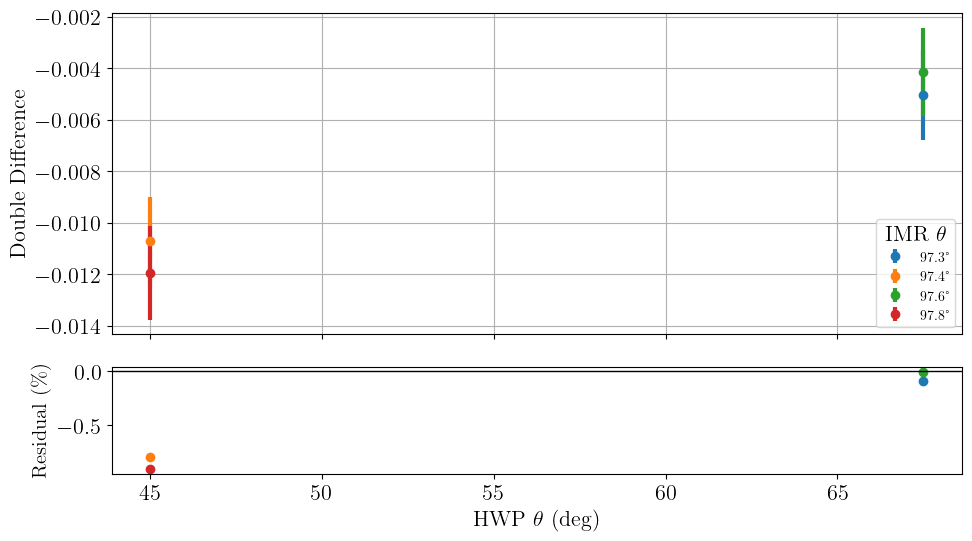

In [5]:

# Get our model retardances from Joost t Hart physical models
bin=20
p = [HWP_retardance(wavelength_bins,1.64601,1.28540)[bin], IMR_retardance(wavelength_bins,259.12694)[bin],M3_diattenuation(wavelength_bins[bin]),M3_retardance(wavelength_bins[bin])]
print(M3_diattenuation(wavelength_bins[4]))

# Define what is in the p list

system_parameters = [['hwp', 'phi'], ['image_rotator', 'phi'],['M3','epsilon'],['M3','phi']]

# Generate our modeled left and right beam intensities

LR_intensities = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(LR_intensities)
print(diffs_sums)
# Plot the modeled and observed values

fig, ax = plot_data_and_model(interleaved_values, interleaved_stds, diffs_sums,configuration_list, wavelength= wavelength_bins[4],include_sums=False,title='')
ax.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax.minorticks_on()
#fig.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/MCMC_model_single_diff_vs_hwp_1931.png',bbox_inches='tight', dpi=600)




   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.7740e+01                                    2.39e+01    
       1              2         4.7740e+01      2.39e-09       1.00e-10       2.39e+01    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 4.7740e+01, final cost 4.7740e+01, first-order optimality 2.39e+01.
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 2.890e+00 -5.111e-05  6.182e+00 -5.257e-05  2.420e+00
               -5.216e-05  6.561e+00 -4.974e-05]
           x: [ 2.000e-10]
        cost: 47.7402995519464
         jac: [[-1.390e+00]
               [ 1.033e-03]
               [-1.364e+00]
               [ 1.088e-03]
               [-1.357e+00]
               [ 1.091e-03]
               [-1.241e+00]
               [ 1.017e-03]]
        grad: [-2.388e+01]
  optimality: 23.876242921602195
 active_mask: [-1]
      

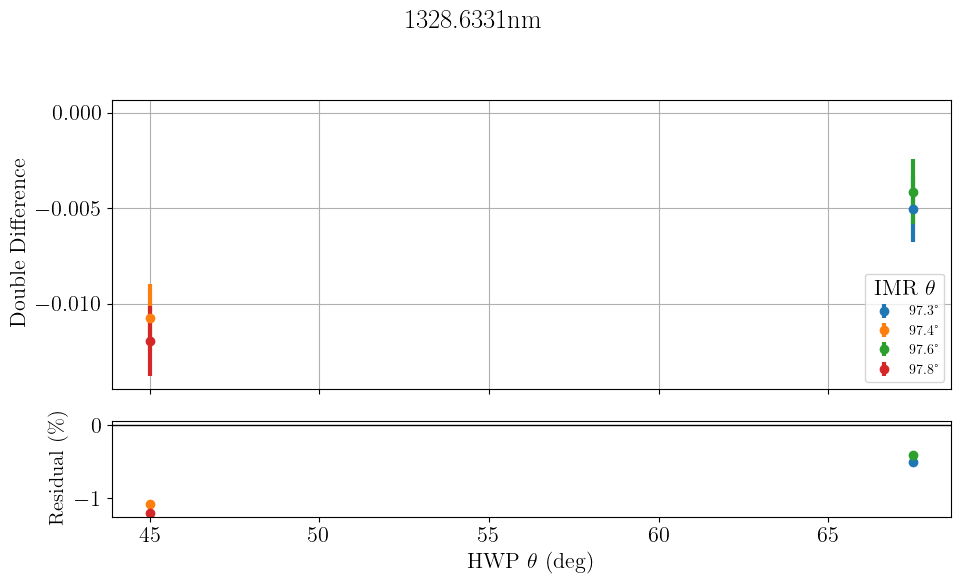

Updated Mueller Matrix:
[[ 0.5        -0.44664841 -0.22473361  0.        ]
 [-0.5         0.44664841  0.22473361  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
16 8
Residuals range: -0.011950183401725215 -0.004133492293014572
Error: [1.37884844]


/var/folders/2v/qmxm7kj51fg6kf7g36xrbysr0000gn/T/ipykernel_9993/2040929531.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


In [6]:
# test minimization

# Test fitting with the wavelength bin we plotted earlier

error, fig2, ax2 = fit_CHARIS_Mueller_matrix_by_bin_m3(filepath, 4, 
    Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/testing_model/BD343631/sys_dicts/test.json'),
    )
ax2.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax2.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax2.minorticks_on()
fig2.suptitle('')
fig2.show()
#fig2.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/naive_model_single_diff_vs_hwp_1329.png',bbox_inches='tight', dpi=600)



In [12]:
# add function to match tags for new stars

from glob import glob
from astropy.io import fits

def match_fits_tags(cubedir):
    """
    Renames DPP processed data to original CHARIS ID.
    
    Parameters
    ----------
    cubedir : str
        Directory containing the processed CHARIS data with format n*.fits.
        Anything not following this format will be ignored.

    Returns
    -------
    None
        Renames files in the cubedir to match the original CHARIS ID.
    """

    cubedir = Path(cubedir)

    # iterate through all fits files in the cubedir, following dpp format of n*.fits
    for proc_file in cubedir.glob('n*.fits'):

        # grab the fits header containing the original id
        with fits.open(proc_file) as hdul:
            header = hdul[0].header
            original_id = header.get('ORIGNAME', None)
            if not original_id:
                raise ValueError(f"No ORIGINAME found in header of {proc_file.name}")
            
        # rename the file to match the original CHARIS ID
        proc_file.rename(cubedir / f"CRSA{original_id}_flat_cube.fits")
        print(f"Renamed {proc_file.name} to CRSA{original_id}_flat_cube.fits")


    





            


In [13]:
cubedir = '/home/thomasmc/charis_mm_testing/HD40280/flat-cubes'
match_fits_tags(cubedir)

Renamed n0054e_flat.fits to CRSA00154273_flat_cube.fits
Renamed n0008e_flat.fits to CRSA00154227_flat_cube.fits
Renamed n0015e_flat.fits to CRSA00154234_flat_cube.fits
Renamed n0085e_flat.fits to CRSA00154304_flat_cube.fits
Renamed n0006e_flat.fits to CRSA00154225_flat_cube.fits
Renamed n0099e_flat.fits to CRSA00154318_flat_cube.fits
Renamed n0035e_flat.fits to CRSA00154254_flat_cube.fits
Renamed n0093e_flat.fits to CRSA00154312_flat_cube.fits
Renamed n0060e_flat.fits to CRSA00154279_flat_cube.fits
Renamed n0063e_flat.fits to CRSA00154282_flat_cube.fits
Renamed n0092e_flat.fits to CRSA00154311_flat_cube.fits
Renamed n0051e_flat.fits to CRSA00154270_flat_cube.fits
Renamed n0070e_flat.fits to CRSA00154289_flat_cube.fits
Renamed n0078e_flat.fits to CRSA00154297_flat_cube.fits
Renamed n0100e_flat.fits to CRSA00154319_flat_cube.fits
Renamed n0027e_flat.fits to CRSA00154246_flat_cube.fits
Renamed n0003e_flat.fits to CRSA00154222_flat_cube.fits
Renamed n0075e_flat.fits to CRSA00154294_flat_cu

In [ ]:
cubedir = '/home/thomasmc/charis_mm_testing/HD40280/flat-cubes'
rawdir = '/home/thomasmc/charis_mm_testing/HD40280/raw'
centroid_guesses = ([70,83],[140,115]) # guesses for PSF centroids
aper_radii = (18,18) # using ~3X FWHM for aperture radius
bkgd_annuli_radii = ([18,28],[18,26]) # annuli for background subtraction
box_size = 65 # box for centroid finder to search

for bin in range(0,22):
    csv_out = f'/home/thomasmc/charis_mm_testing/HD40280/csvs/bin{bin}.csv'
    write_fits_info_to_csv_psf(cubedir,rawdir,csv_out,centroid_guesses,
                               aper_radii,box_size,bin,hwp_order=None,bkgd_annuli_radii=bkgd_annuli_radii,plot_every_x=25)


In [9]:
# do everything again for hd35532
cubedir2 = '/home/thomasmc/charis_mm_testing/HD35532/flat-cubes'
match_fits_tags(cubedir2)


Renamed n0054e_flat.fits to CRSA00155533_flat_cube.fits
Renamed n0008e_flat.fits to CRSA00155487_flat_cube.fits
Renamed n0015e_flat.fits to CRSA00155494_flat_cube.fits
Renamed n0085e_flat.fits to CRSA00155564_flat_cube.fits
Renamed n0006e_flat.fits to CRSA00155485_flat_cube.fits
Renamed n0099e_flat.fits to CRSA00155578_flat_cube.fits
Renamed n0035e_flat.fits to CRSA00155514_flat_cube.fits
Renamed n0093e_flat.fits to CRSA00155572_flat_cube.fits
Renamed n0060e_flat.fits to CRSA00155539_flat_cube.fits
Renamed n0063e_flat.fits to CRSA00155542_flat_cube.fits
Renamed n0092e_flat.fits to CRSA00155571_flat_cube.fits
Renamed n0051e_flat.fits to CRSA00155530_flat_cube.fits
Renamed n0070e_flat.fits to CRSA00155549_flat_cube.fits
Renamed n0078e_flat.fits to CRSA00155557_flat_cube.fits
Renamed n0100e_flat.fits to CRSA00155579_flat_cube.fits
Renamed n0027e_flat.fits to CRSA00155506_flat_cube.fits
Renamed n0003e_flat.fits to CRSA00155482_flat_cube.fits
Renamed n0075e_flat.fits to CRSA00155554_flat_cu

In [ ]:
cubedir = '/home/thomasmc/charis_mm_testing/HD35532/flat-cubes'
rawdir = '/home/thomasmc/charis_mm_testing/HD35532/raw'
centroid_guesses = ([68,81],[132,114]) # guesses for PSF centroids
aper_radii = (18,18) # using <~3X FWHM for aperture radius due to space
bkgd_annuli_radii = ([18,26],[18,28]) # annuli for background subtraction
box_size = 51 # box for centroid finder to search

for bin in range(0,22):
    csv_out = f'/home/thomasmc/charis_mm_testing/HD35532/csvs/bin{bin}.csv'
    write_fits_info_to_csv_psf(cubedir,rawdir,csv_out,centroid_guesses,
                               aper_radii,box_size,bin,hwp_order=None,bkgd_annuli_radii=bkgd_annuli_radii,plot_every_x=25)


In [14]:
# fix corrupted csv arrangement on bd csv
import pandas as pd
# csv_bd = glob('/home/thomasmc/charis_mm_testing/BD343631-broadband-unpol/csvs/csvs/*.csv')
# for csv in csv_bd:
#     df = pd.read_csv(csv)
#     df = df.sort_values(by='filepath')
#     df.to_csv(csv,index=False)



In [11]:
# delete the last row from all hd 40280 csvs to make even hwp cycles
from glob import glob
import pandas as pd
# csv_files = glob('/home/thomasmc/charis_mm_testing/HD40280/csvs/*.csv')
# for csv_file in csv_files:
#     df = pd.read_csv(csv_file)
#     df = df[:-1]  # remove the last row
#     df.to_csv(csv_file, index=False)
#     print(f"Removed last row from {csv_file}")

Removed last row from /home/thomasmc/charis_mm_testing/HD40280/csvs/bin13.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD40280/csvs/bin10.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD40280/csvs/bin0.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD40280/csvs/bin15.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD40280/csvs/bin17.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD40280/csvs/bin19.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD40280/csvs/bin8.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD40280/csvs/bin11.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD40280/csvs/bin2.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD40280/csvs/bin1.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD40280/csvs/bin18.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD40280/csvs/bin6.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD40280/csvs/b

In [21]:
# remove first row from hd 35532 csvs to make even hwp cycles
from glob import glob
import pandas as pd
# csv_files = glob('/home/thomasmc/charis_mm_testing/HD35532/csvs/*.csv')
# for csv_file in csv_files:
#     df = pd.read_csv(csv_file)
#     df = df[1:]  # remove the first row
#     df.to_csv(csv_file, index=False)
#     print(f"Removed last row from {csv_file}")


Removed last row from /home/thomasmc/charis_mm_testing/HD35532/csvs/bin13.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD35532/csvs/bin10.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD35532/csvs/bin0.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD35532/csvs/bin15.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD35532/csvs/bin17.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD35532/csvs/bin19.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD35532/csvs/bin8.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD35532/csvs/bin11.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD35532/csvs/bin2.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD35532/csvs/bin1.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD35532/csvs/bin18.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD35532/csvs/bin6.csv
Removed last row from /home/thomasmc/charis_mm_testing/HD35532/csvs/b

In [22]:
# concantate all csvs into one csv

import pandas as pd
from pathlib import Path

# Paths to your three folders
bdcsvs = Path("/home/thomasmc/charis_mm_testing/BD343631-broadband-unpol/csvs/csvs")
hd4csvs= Path("/home/thomasmc/charis_mm_testing/HD40280/csvs")
hd3csvs = Path("/home/thomasmc/charis_mm_testing/HD35532/csvs")

# Where to save outputs
outdir = Path("/home/thomasmc/charis_mm_testing/m3-fit/csvs")

# Get all CSVs in folder1 (use it as the reference set of bin numbers)
for file1 in bdcsvs.glob("bin*.csv"):
    bin_num = file1.stem  # e.g. "bin12"
    file2 = hd4csvs / f"{bin_num}.csv"
    file3 = hd3csvs / f"{bin_num}.csv"

    # Only process if all three exist
    if file2.exists() and file3.exists():
        # Read CSVs
        df1 = pd.read_csv(file1)
        df2 = pd.read_csv(file2)
        df3 = pd.read_csv(file3)

        # Concatenate while keeping only one header
        combined = pd.concat([df1, df2, df3], ignore_index=True)

        # Save result
        combined.to_csv(outdir / f"{bin_num}.csv", index=False)
        print(f"Combined {file1.name}, {file2.name}, {file3.name} → {bin_num}.csv")
    else:
        missing = [f for f in [file2, file3] if not f.exists()]
        print(f"Skipping {bin_num}: missing {', '.join(m.name for m in missing)}")


Combined bin13.csv, bin13.csv, bin13.csv → bin13.csv
Combined bin10.csv, bin10.csv, bin10.csv → bin10.csv
Combined bin0.csv, bin0.csv, bin0.csv → bin0.csv
Combined bin15.csv, bin15.csv, bin15.csv → bin15.csv
Combined bin17.csv, bin17.csv, bin17.csv → bin17.csv
Combined bin19.csv, bin19.csv, bin19.csv → bin19.csv
Combined bin8.csv, bin8.csv, bin8.csv → bin8.csv
Combined bin11.csv, bin11.csv, bin11.csv → bin11.csv
Combined bin2.csv, bin2.csv, bin2.csv → bin2.csv
Combined bin1.csv, bin1.csv, bin1.csv → bin1.csv
Combined bin18.csv, bin18.csv, bin18.csv → bin18.csv
Combined bin6.csv, bin6.csv, bin6.csv → bin6.csv
Combined bin16.csv, bin16.csv, bin16.csv → bin16.csv
Combined bin4.csv, bin4.csv, bin4.csv → bin4.csv
Combined bin7.csv, bin7.csv, bin7.csv → bin7.csv
Combined bin5.csv, bin5.csv, bin5.csv → bin5.csv
Combined bin14.csv, bin14.csv, bin14.csv → bin14.csv
Combined bin9.csv, bin9.csv, bin9.csv → bin9.csv
Combined bin12.csv, bin12.csv, bin12.csv → bin12.csv
Combined bin21.csv, bin21.csv

In [2]:
# Plotting data with original model

filepath = Path('datacsvs/onsky_csvs/unpol_standards/bin4.csv')

# Read in data

interleaved_values, interleaved_stds, configuration_list = read_csv(filepath,mode='m3')
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values[0 : 10])
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list[0 : 10])
print(interleaved_stds[0])

Interleaved Values
Length:  424
[  8443.27609806 183984.02310066   4012.12686473 186817.75324261
   6639.70820973 188585.58588432   5136.85028889 174995.08972068
   7617.45042424 174256.8746022 ]
Interleaved Stds
Length:  424
[495.60723263 495.60723263 458.68462679 458.68462679 468.042866
 468.042866   408.14944837 408.14944837 422.24666243 422.24666243]
Configuration List
Length:  212
[{'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 97.8916}, 'altitude_rot': {'pa': 66.77899114}, 'parang_rot': {'pa': 126.5757623688055}}, {'hwp': {'theta': 45.0}, 'image_rotator': {'theta': 97.80772}, 'altitude_rot': {'pa': 66.60077713}, 'parang_rot': {'pa': 126.1145151377112}}, {'hwp': {'theta': 22.5}, 'image_rotator': {'theta': 97.70938}, 'altitude_rot': {'pa': 66.4212248}, 'parang_rot': {'pa': 125.6585613281019}}, {'hwp': {'theta': 67.5}, 'image_rotator': {'theta': 97.61756}, 'altitude_rot': {'pa': 66.24067105}, 'parang_rot': {'pa': 125.2092898301123}}, {'hwp': {'theta': 0.0}, 'image_rotator': {'th

In [5]:

# Loading in past fits 

offset_imr = 0.13214 # derotator offset
offset_hwp = -0.99287 # HWP offset
offset_cal = 0.49797 # calibration polarizer offset
imr_theta = 0
hwp_theta = 0
m3_diat = M3_diattenuation(wavelength_bins[4])
m3_ret = M3_retardance(wavelength_bins[4])

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "altitude_rot" : {
                "type" : "rotator_function",
                "properties" : {"pa":77},
                "tag":"internal",
            },
            "M3" : {
                "type" : "diattenuator_retarder_function",
                "properties" : {'phi': m3_ret, "epsilon" : m3_diat},
                "tag": "internal",
            },
            "parang_rot" : {
                "type" : "rotator_function",
                "properties" : {"pa":39},
                "tag":"internal",
            },
            }
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())



[[ 0.49604655  0.118807   -0.48019314  0.03690017]
 [ 0.49604655  0.118807   -0.48019314  0.03690017]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


0.00879723920666722
[ 1.17310592e-03  6.43343469e-05  8.67509178e-03  4.36284533e-05
  1.17176931e-03  6.02185609e-05  8.67534960e-03  4.37732348e-05
  1.15365120e-03  5.21022139e-05  8.67124856e-03  3.89256336e-05
  1.15985594e-03  4.80188243e-05  8.67117431e-03  3.81341392e-05
  1.15792262e-03  5.10356330e-05  8.67167986e-03  3.83467478e-05
  1.15439245e-03  4.93112561e-05  8.67155990e-03  3.84392941e-05
  1.15126454e-03  4.85984324e-05  8.67085172e-03  3.84412927e-05
  1.16048145e-03  4.62076099e-05  8.67105024e-03  3.78239385e-05
  1.15423963e-03  4.53513617e-05  8.67078550e-03  3.73521307e-05
  1.16075847e-03  4.51809819e-05  8.67034215e-03  3.75836206e-05
  1.15714960e-03  5.12948518e-05  8.67066468e-03  3.69075861e-05
  1.16249337e-03  4.66435379e-05  8.67019841e-03  3.67643791e-05
  1.15805444e-03  5.10372681e-05  8.66986155e-03  3.60394282e-05
  1.15026783e-03  4.47662239e-05  8.66987312e-03  3.68072057e-05
  1.15413396e-03  4.05362030e-05  8.66989475e-03  3.62096219e-05
  1.1

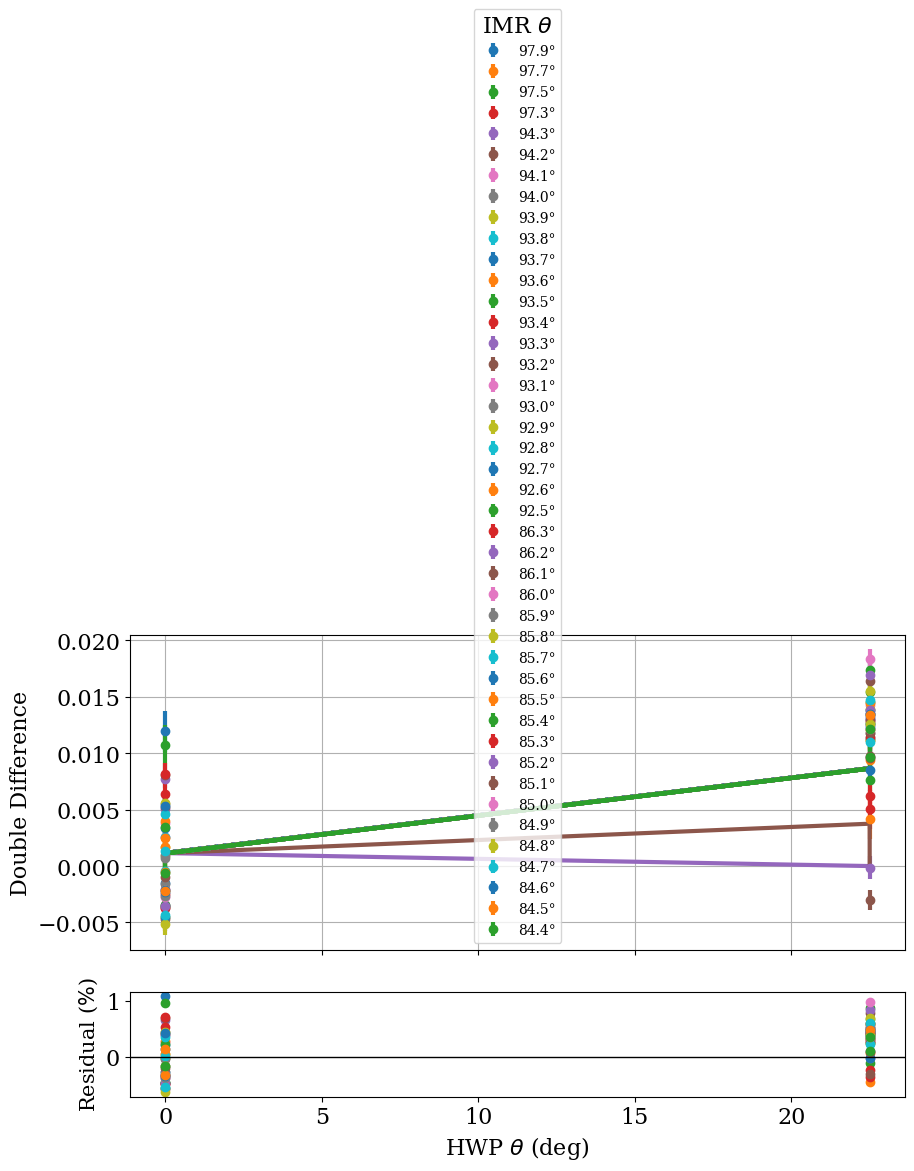

In [6]:

# Get our model retardances from Joost t Hart physical models
bin=4
p = [HWP_retardance(wavelength_bins,1.64601,1.28540)[bin], IMR_retardance(wavelength_bins,259.12694)[bin],M3_retardance(wavelength_bins[bin])]
print(M3_diattenuation(wavelength_bins[4]))

# Define what is in the p list

system_parameters = [['hwp', 'phi'], ['image_rotator', 'phi'],['M3','phi']]

# Generate our modeled left and right beam intensities

LR_intensities = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(LR_intensities)
print(diffs_sums)
# Plot the modeled and observed values

fig, ax = plot_data_and_model(interleaved_values, interleaved_stds, diffs_sums,configuration_list, wavelength= wavelength_bins[4],include_sums=False,title='')
ax.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax.minorticks_on()
# #fig.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/MCMC_model_single_diff_vs_hwp_1931.png',bbox_inches='tight', dpi=600)




/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 938.7455068162342
       x: [ 9.803e-01 -1.921e-01  4.689e-02  9.906e-01  3.633e+00]
     nit: 38
     jac: [-7.741e+03  1.452e+03 -4.252e+02 -7.629e-05 -1.536e+00]
    nfev: 298
    njev: 34
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 938.7445855426704
       x: [ 9.803e-01 -1.921e-01  4.689e-02  9.906e-01  3.633e+00]
     nit: 1
     jac: [-7.741e+03  1.452e+03 -4.252e+02 -7.629e-05 -1.536e+00]
    nfev: 14
    njev: 1


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


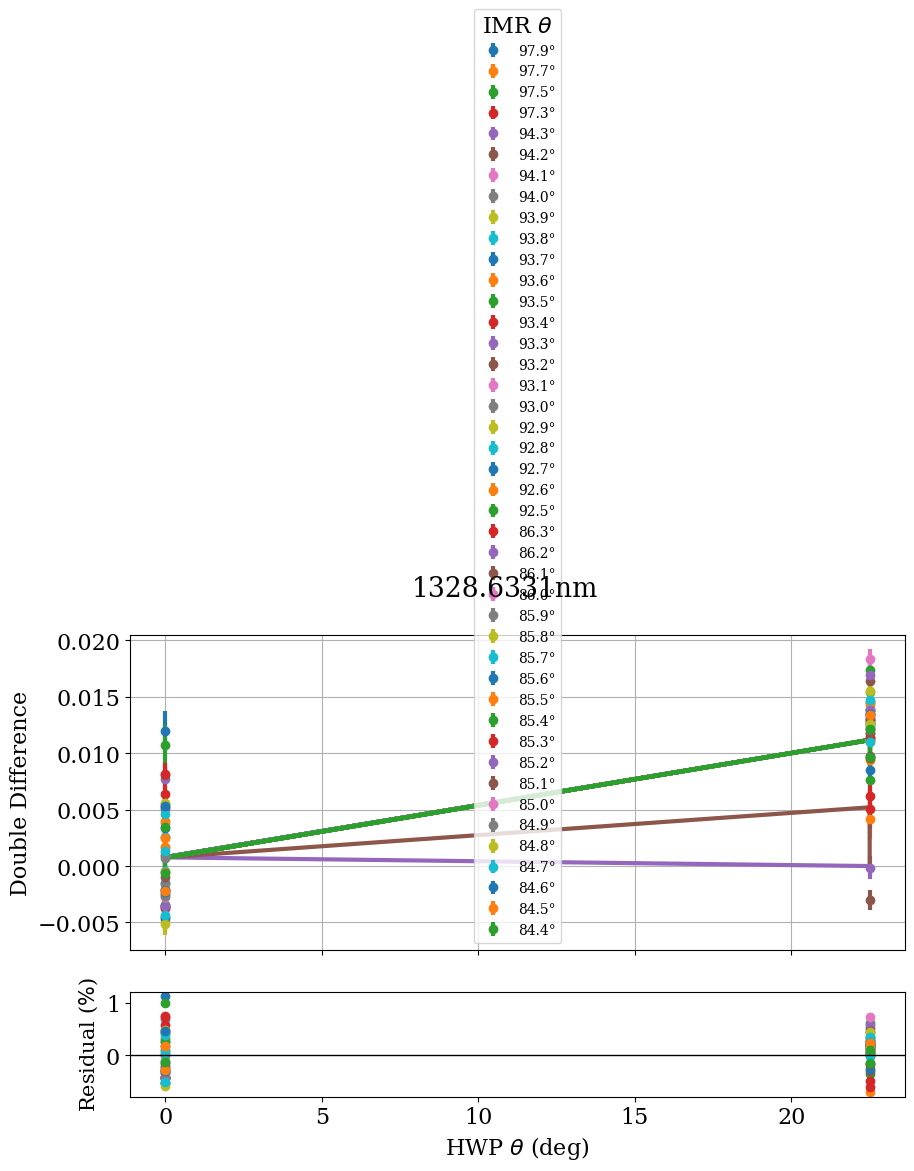

Updated Mueller Matrix:
[[ 0.01176311 -0.01041867  0.00543713  0.00050525]
 [ 0.00846982 -0.00748309  0.0039489   0.00038987]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
424 212
Residuals range: -0.7032593850191609 1.1165406569098388
s_res: 0.3759803804658947


/var/folders/2v/qmxm7kj51fg6kf7g36xrbysr0000gn/T/ipykernel_86937/1974539896.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


In [3]:
# test minimization

# Test fitting with the wavelength bin we plotted earlier

fig2, ax2,sres = fit_CHARIS_Mueller_matrix_by_bin_m3(filepath, 4, 
    Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/unpol_imr_diat_fit/test.json'),
    )
ax2.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax2.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax2.minorticks_on()
fig2.suptitle('')
fig2.show()
#fig2.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/naive_model_single_diff_vs_hwp_1329.png',bbox_inches='tight', dpi=600)



/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 795.80595384063
       x: [ 9.893e-01 -1.452e-01 -9.955e-03  9.863e-01  1.766e+00]
     nit: 44
     jac: [-1.725e+03  2.016e+02 -1.140e+01  1.221e-04 -1.771e+00]
    nfev: 343
    njev: 40
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 795.7969195402371
       x: [ 9.893e-01 -1.452e-01 -9.951e-03  9.863e-01  1.766e+00]
     nit: 6
     jac: [-4.096e+03  5.463e+02  1.155e+01 -1.450e-04 -1.784e+00]
    nfev: 62
    njev: 5


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


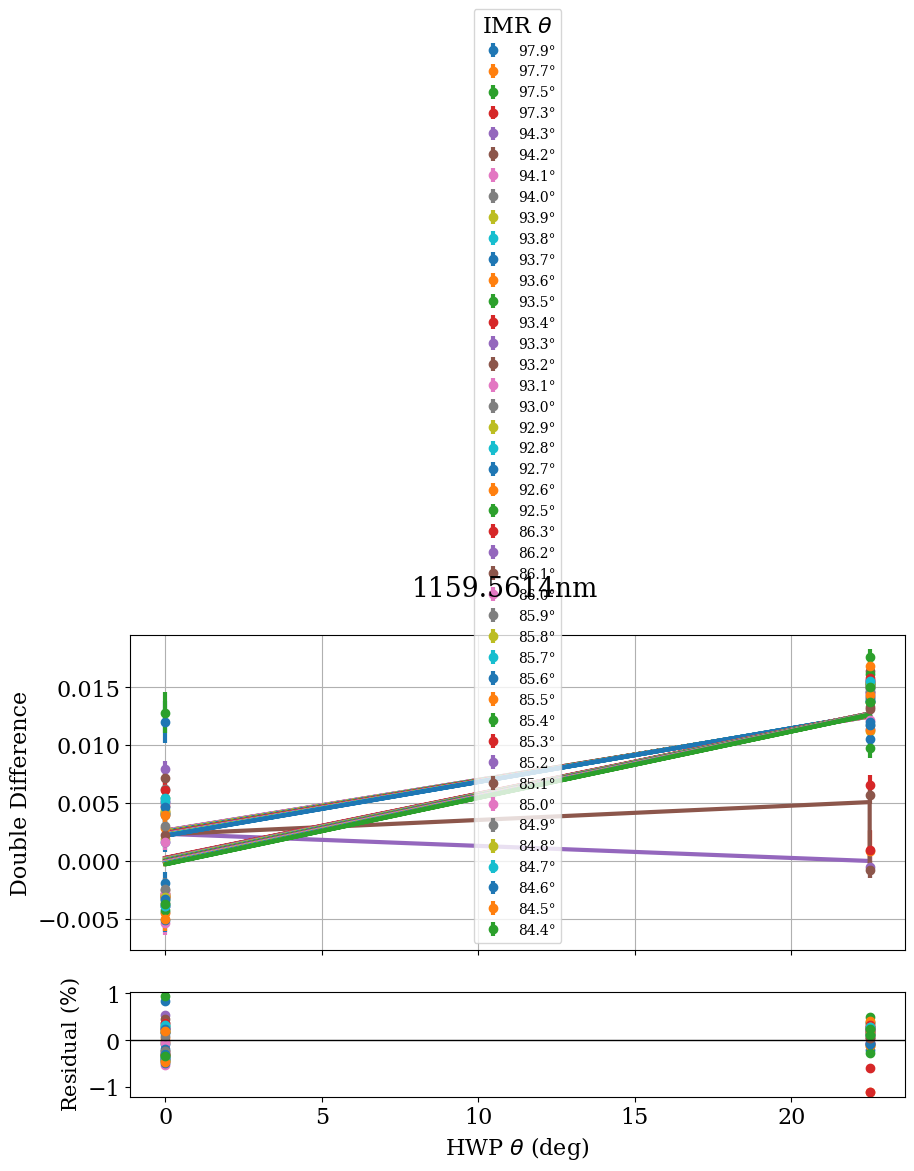

Updated Mueller Matrix:
[[ 0.00178934 -0.00163997  0.00067047  0.00025043]
 [-0.00178934  0.00163997 -0.00067047 -0.00025043]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
424 212
Residuals range: -1.1120250836448033 0.9357252645756742
s_res: 0.33900127029997323


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Singular matrix E in LSQ subproblem
 success: False
  status: 5
     fun: 635.4584212708979
       x: [ 9.700e-01 -2.404e-01 -3.485e-02  9.873e-01  4.196e+00]
     nit: 29
     jac: [       nan -3.906e+02 -1.735e+02 -1.602e-04 -2.453e+00]
    nfev: 230
    njev: 29
 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 635.4584212708979
       x: [ 9.700e-01 -2.404e-01 -3.485e-02  9.873e-01  4.196e+00]
     nit: 1
     jac: [       nan -3.906e+02 -1.735e+02 -1.602e-04 -2.453e+00]
    nfev: 6
    njev: 1


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


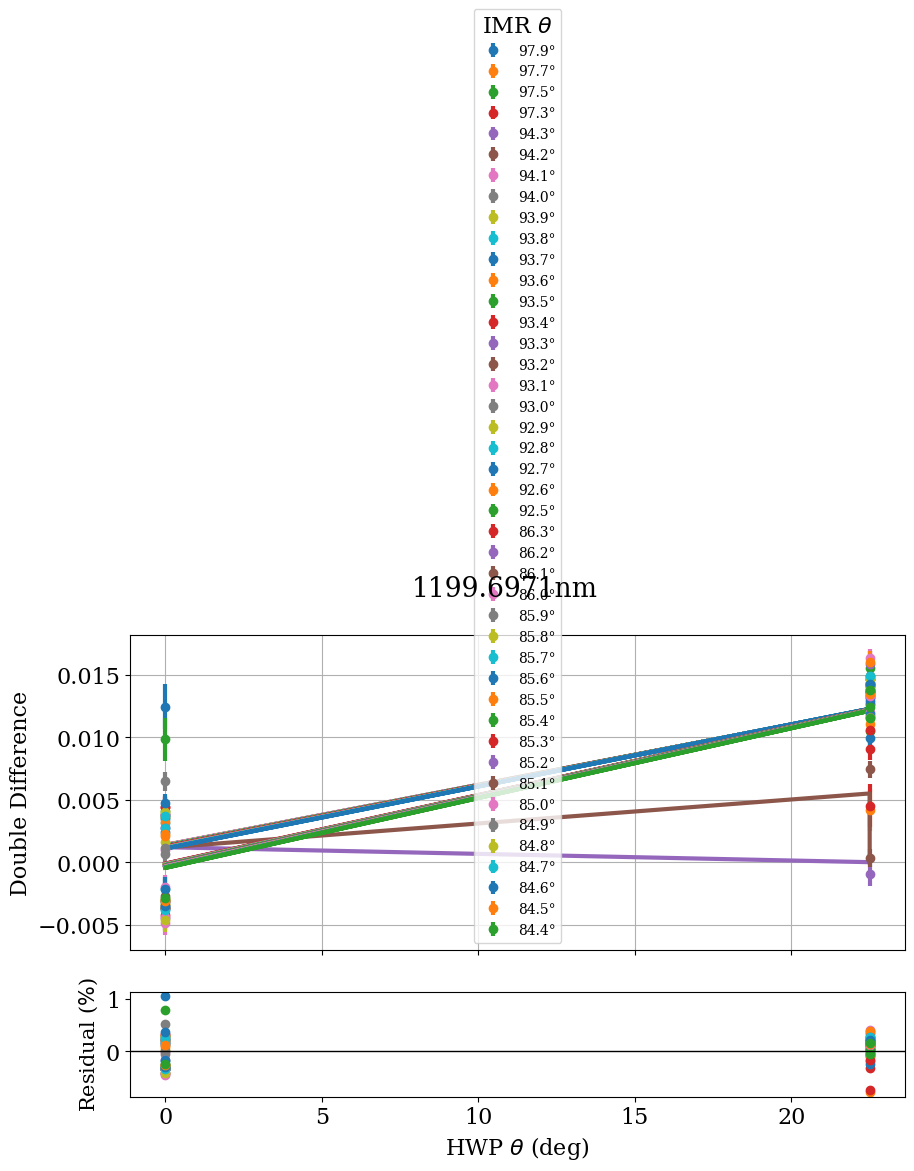

Updated Mueller Matrix:
[[ 0.00649942 -0.00594225  0.00242541  0.00102443]
 [ 0.00126924 -0.00115723  0.00047976  0.00020421]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
424 212
Residuals range: -0.7773811097113381 1.048481398583857
s_res: 0.29210765349375767


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 835.3180337298543
       x: [ 9.812e-01 -1.928e-01  1.113e-02  9.895e-01  2.910e+00]
     nit: 31
     jac: [-1.388e+03  1.817e+02 -8.387e+01 -3.052e-05 -3.106e+00]
    nfev: 239
    njev: 29
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 835.3134409716192
       x: [ 9.812e-01 -1.928e-01  1.113e-02  9.895e-01  2.910e+00]
     nit: 3
     jac: [-3.771e+03  6.395e+02 -1.111e+02 -7.629e-05 -3.131e+00]
    nfev: 38
    njev: 3


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


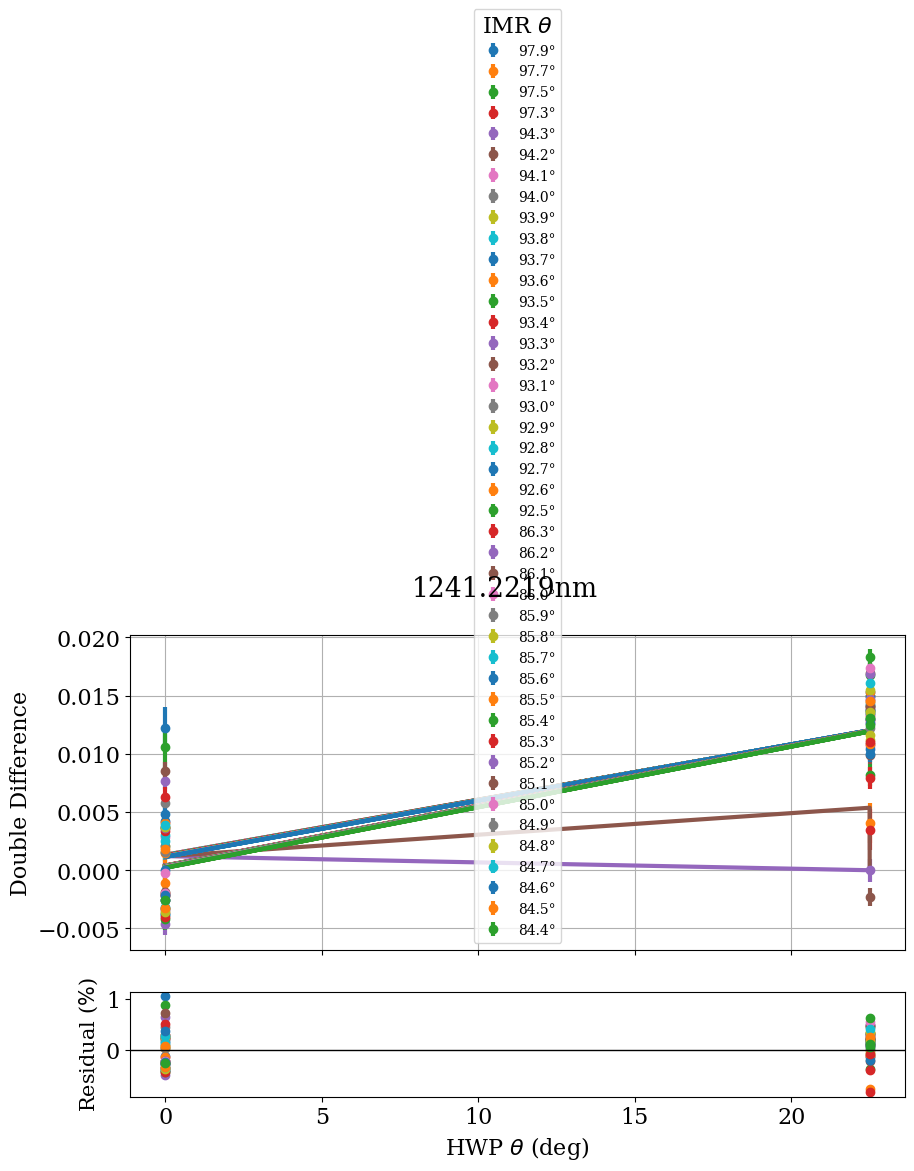

Updated Mueller Matrix:
[[ 3.86022329e-03 -3.47093068e-03  1.61896541e-03  4.81881950e-04]
 [-4.72229102e-04  4.34697988e-04 -1.81884007e-04 -4.07553612e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
424 212
Residuals range: -0.8348234192537223 1.0491755334834778
s_res: 0.339058614017849


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 663.952597979076
       x: [ 9.663e-01 -2.568e-01  1.697e-02  9.869e-01  4.512e+00]
     nit: 34
     jac: [-6.608e+03  1.554e+03 -1.876e+02  9.155e-05 -3.206e+00]
    nfev: 270
    njev: 30
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 663.952514607406
       x: [ 9.663e-01 -2.568e-01  1.697e-02  9.869e-01  4.512e+00]
     nit: 1
     jac: [-7.231e+03  1.688e+03 -1.969e+02 -4.578e-05 -3.206e+00]
    nfev: 15
    njev: 1


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


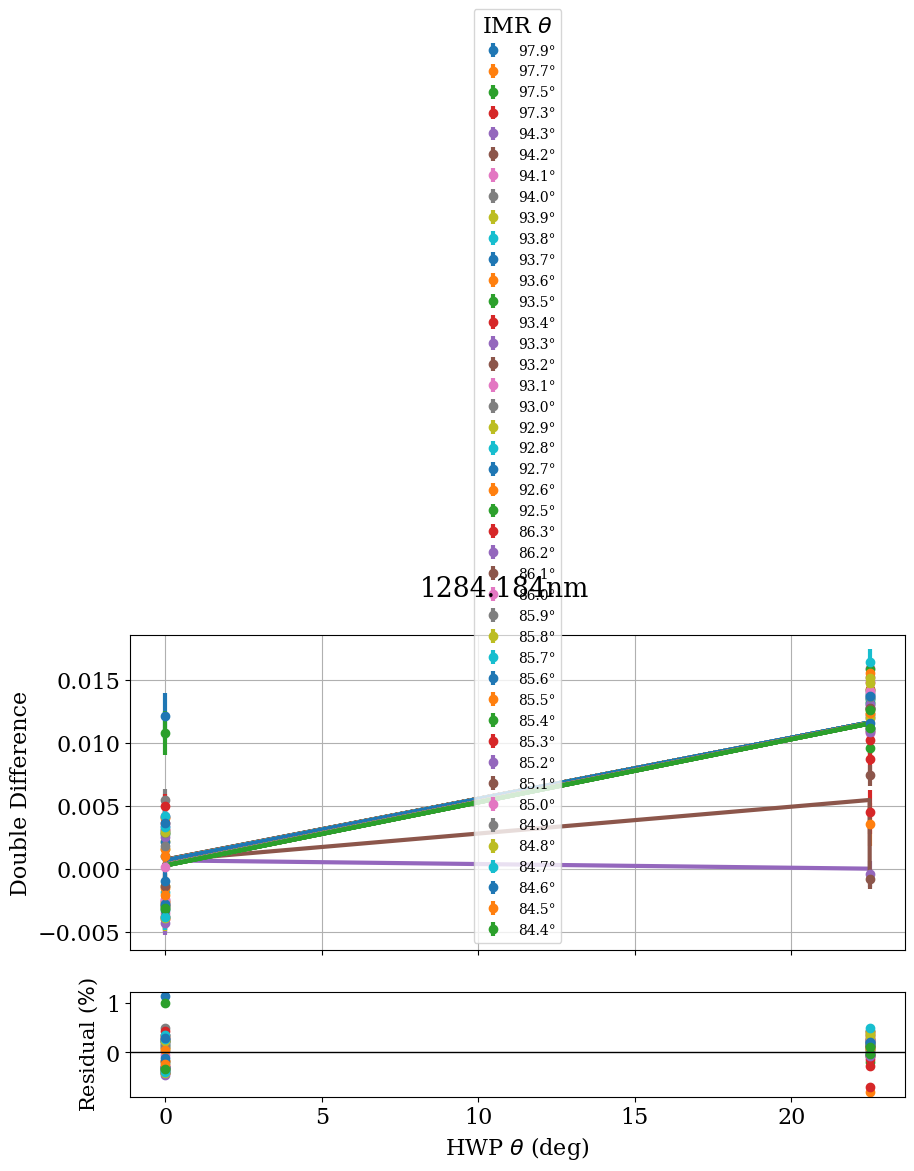

Updated Mueller Matrix:
[[ 0.00889327 -0.0079933   0.00379371  0.00089702]
 [ 0.00356543 -0.00319497  0.0015386   0.00037125]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
424 212
Residuals range: -0.8007843817776009 1.1234089607967415
s_res: 0.3123952160409803


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 938.7455068162342
       x: [ 9.803e-01 -1.921e-01  4.689e-02  9.906e-01  3.633e+00]
     nit: 38
     jac: [-7.741e+03  1.452e+03 -4.252e+02 -7.629e-05 -1.536e+00]
    nfev: 298
    njev: 34
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 938.7445855426704
       x: [ 9.803e-01 -1.921e-01  4.689e-02  9.906e-01  3.633e+00]
     nit: 1
     jac: [-7.741e+03  1.452e+03 -4.252e+02 -7.629e-05 -1.536e+00]
    nfev: 14
    njev: 1


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


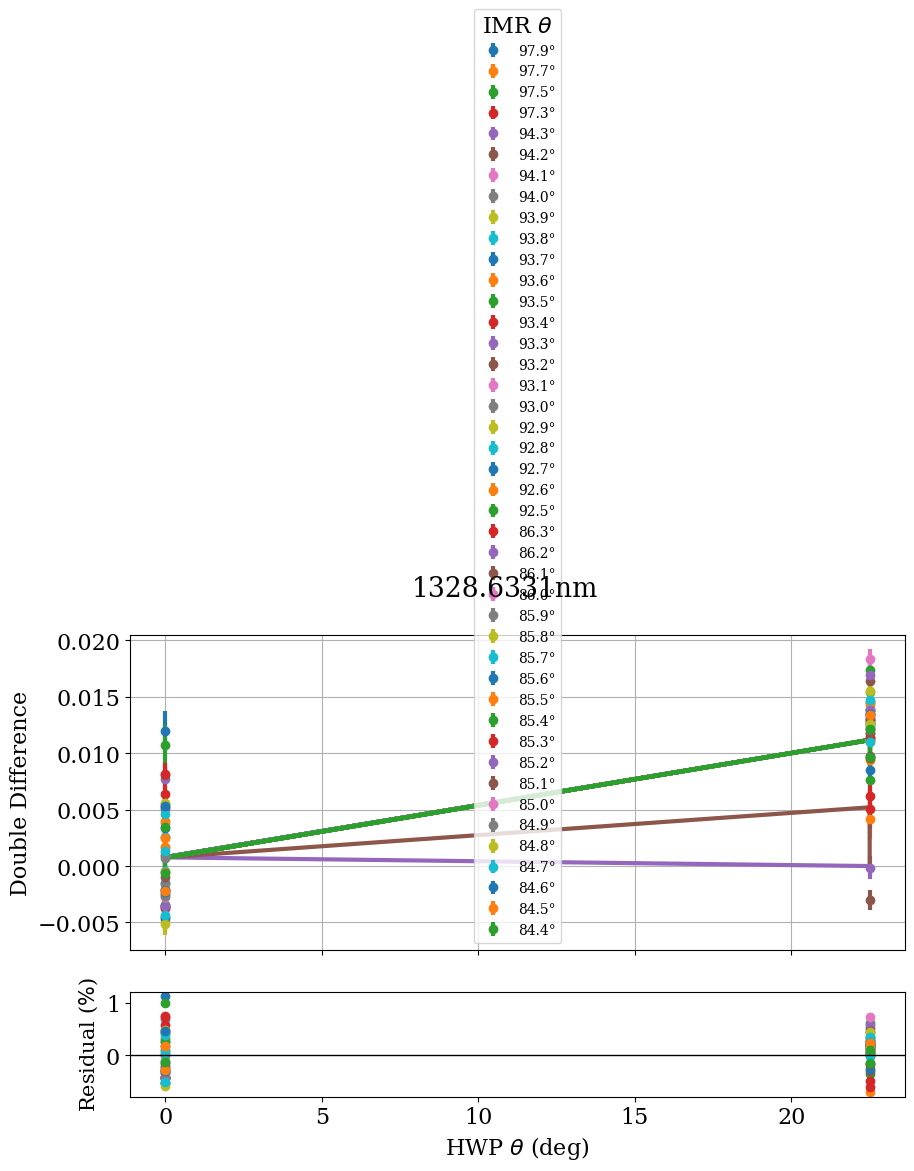

Updated Mueller Matrix:
[[ 0.01176311 -0.01041867  0.00543713  0.00050525]
 [ 0.00846982 -0.00748309  0.0039489   0.00038987]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
424 212
Residuals range: -0.7032593850191609 1.1165406569098388
s_res: 0.3759803804658947


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1226.090251829623
       x: [ 9.854e-01 -1.485e-01  8.365e-02  9.896e-01  3.768e+00]
     nit: 37
     jac: [-4.550e+03  6.984e+02 -4.410e+02 -9.155e-05  4.853e-01]
    nfev: 271
    njev: 33
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1226.0741164201722
       x: [ 9.854e-01 -1.485e-01  8.365e-02  9.896e-01  3.768e+00]
     nit: 3
     jac: [-2.174e+04  3.150e+03 -1.837e+03 -3.052e-05  4.703e-01]
    nfev: 39
    njev: 3


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


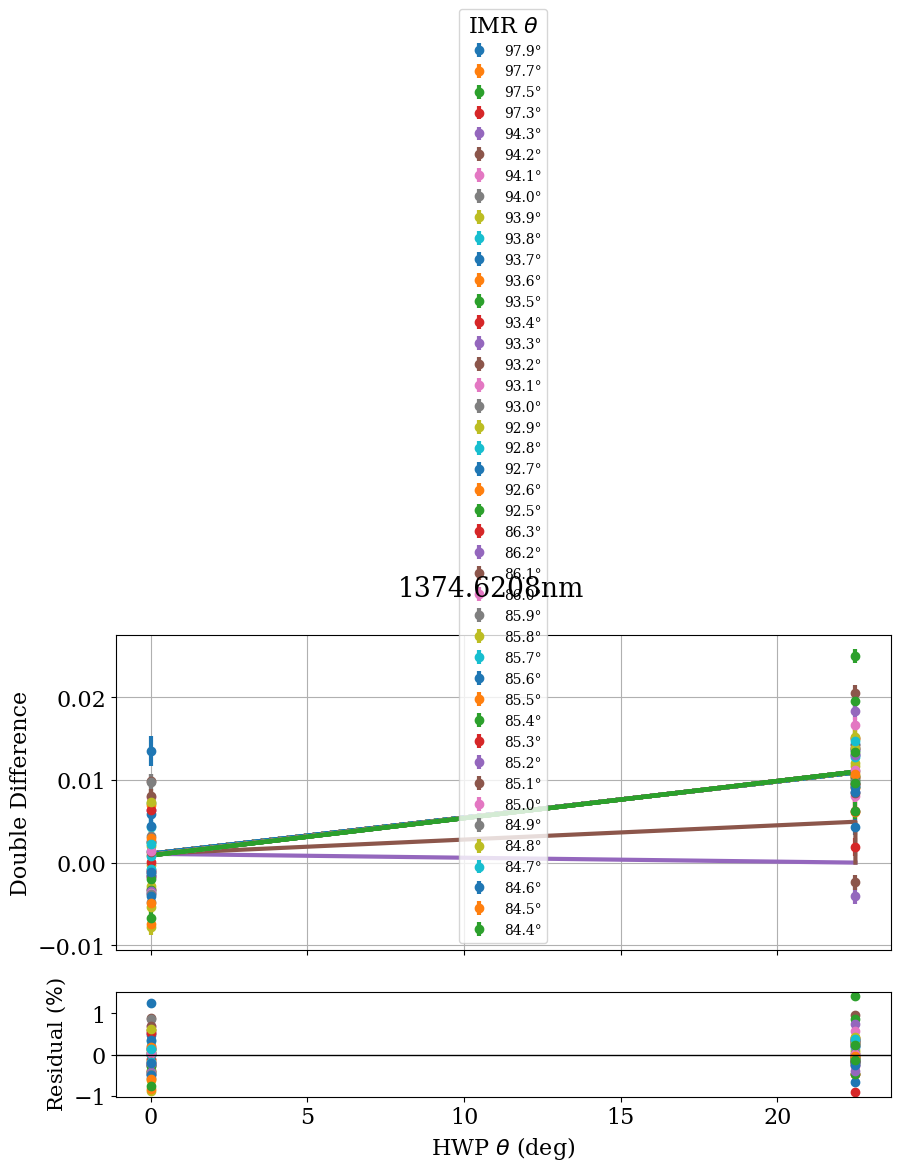

Updated Mueller Matrix:
[[ 0.00742001 -0.00656121  0.00344127 -0.00040456]
 [ 0.00377145 -0.00332824  0.00176458 -0.00018426]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
424 212
Residuals range: -0.9015080687937065 1.4031574171242254
s_res: 0.4462707606976324


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 712.4978181422152
       x: [ 9.849e-01 -1.596e-01  6.707e-02  9.893e-01  4.023e+00]
     nit: 39
     jac: [-2.809e+03  3.851e+02 -2.289e+02 -1.221e-04 -2.368e+00]
    nfev: 296
    njev: 35
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 712.4937816355271
       x: [ 9.849e-01 -1.596e-01  6.707e-02  9.893e-01  4.023e+00]
     nit: 2
     jac: [-4.371e+03  6.348e+02 -3.341e+02 -1.526e-05 -2.377e+00]
    nfev: 26
    njev: 2


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


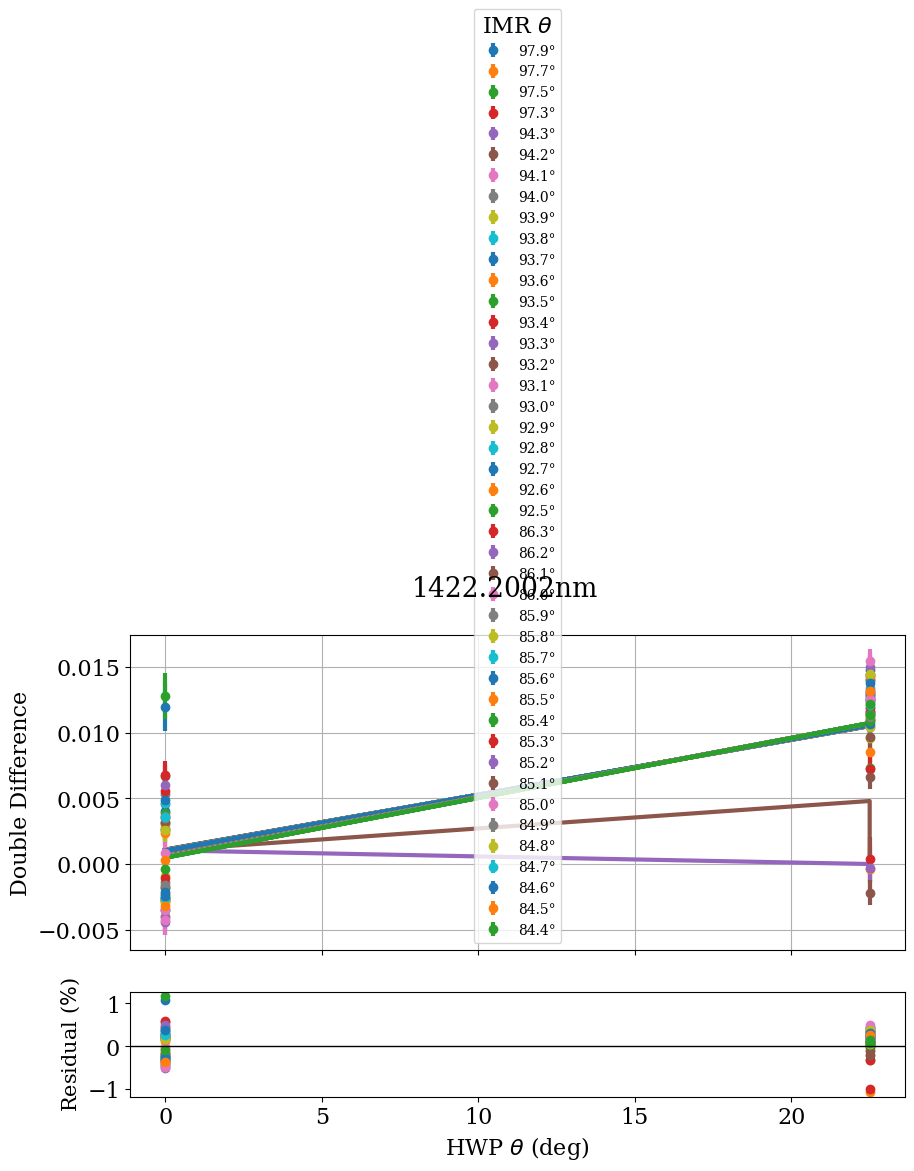

Updated Mueller Matrix:
[[ 0.00617254 -0.00556786  0.00263142 -0.00041063]
 [ 0.00372934 -0.00334362  0.00163936 -0.00021621]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
424 212
Residuals range: -1.0686703914654492 1.1547934853541837
s_res: 0.34991045421903894


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 669.7737597263731
       x: [ 9.883e-01 -1.033e-01  1.120e-01  9.909e-01  2.731e+00]
     nit: 24
     jac: [-2.149e+03  1.662e+02 -2.524e+02 -4.578e-05 -2.011e+00]
    nfev: 189
    njev: 23
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 669.754508275395
       x: [ 9.883e-01 -1.033e-01  1.120e-01  9.909e-01  2.731e+00]
     nit: 8
     jac: [-2.044e+04  1.929e+03 -2.190e+03 -1.221e-04 -2.049e+00]
    nfev: 75
    njev: 6


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


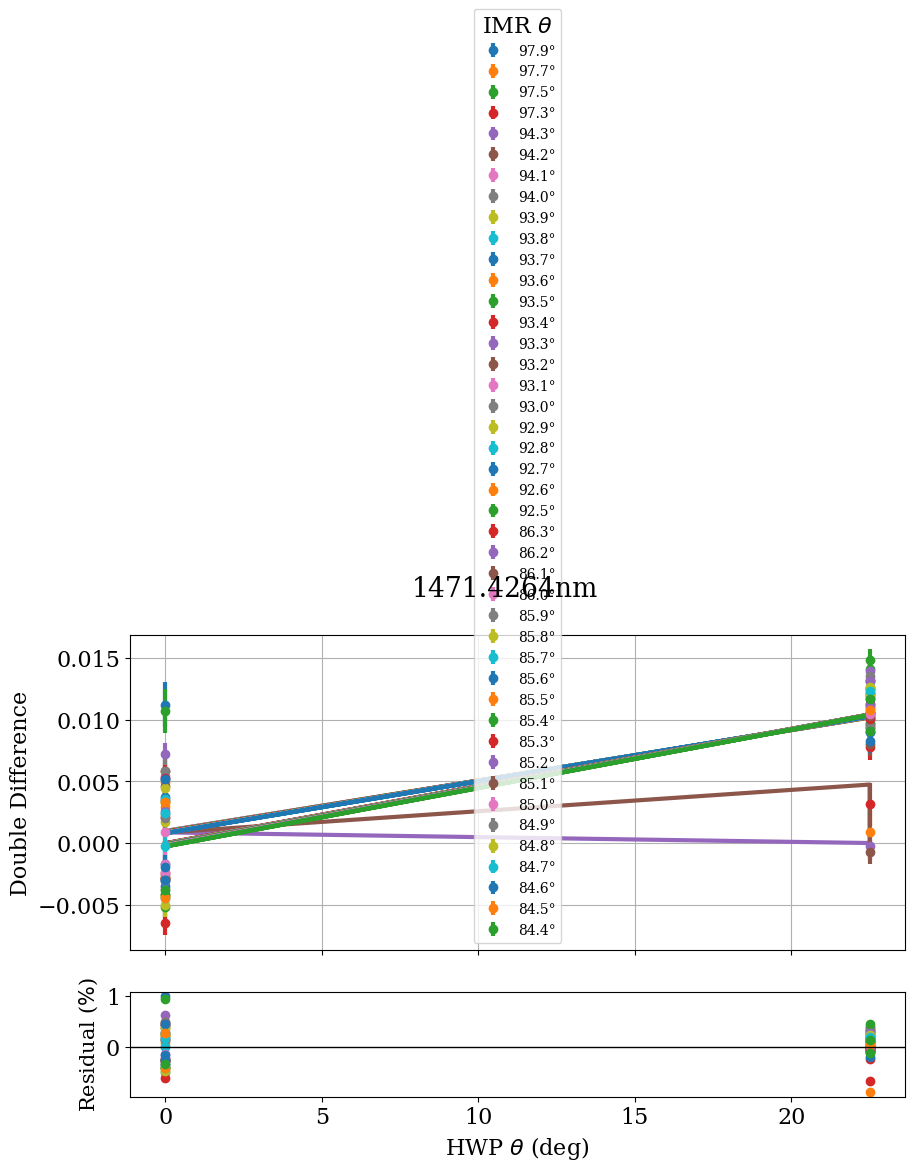

Updated Mueller Matrix:
[[ 7.19724841e-03 -6.68147991e-03  2.55219768e-03 -8.02552751e-04]
 [ 8.86046788e-04 -8.17120642e-04  3.31255398e-04 -8.98313976e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
424 212
Residuals range: -0.8987055487469776 0.9891409957892833
s_res: 0.3212753825069977


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 604.140812606284
       x: [ 9.896e-01 -7.572e-02  1.221e-01  9.891e-01  3.032e+00]
     nit: 36
     jac: [-6.820e+03  4.680e+02 -8.149e+02 -1.526e-05 -1.593e+00]
    nfev: 295
    njev: 32
 message: Singular matrix E in LSQ subproblem
 success: False
  status: 5
     fun: 604.1378190694072
       x: [ 9.896e-01 -7.572e-02  1.221e-01  9.891e-01  3.032e+00]
     nit: 15
     jac: [       nan  2.785e+03 -4.992e+03 -7.629e-05 -1.598e+00]
    nfev: 144
    njev: 11


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


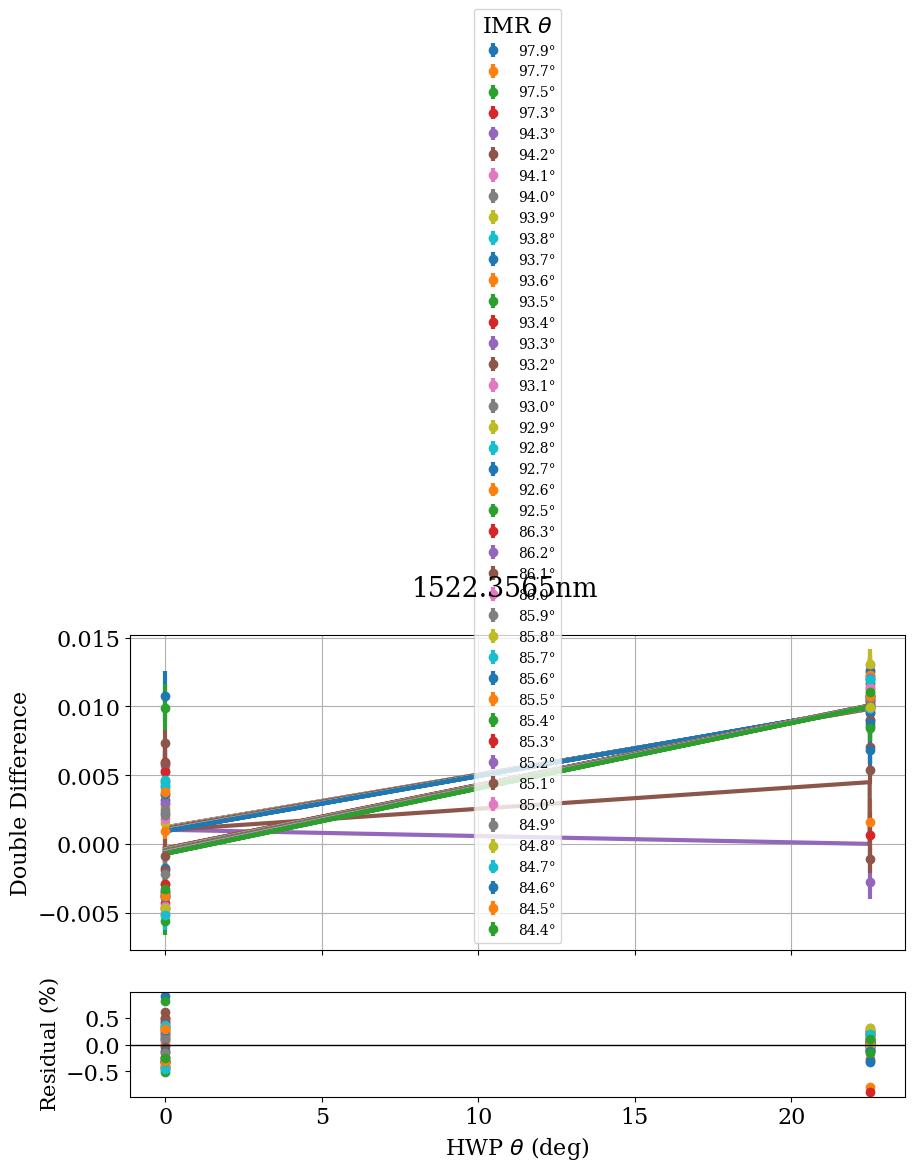

Updated Mueller Matrix:
[[ 8.28853443e-03 -7.80034069e-03  2.54166939e-03 -1.18081937e-03]
 [ 4.17444550e-04 -3.91185617e-04  1.35076881e-04 -5.53019942e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
424 212
Residuals range: -0.889320241962061 0.9004195099371695
s_res: 0.30228376838485355


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 640.9869602550837
       x: [ 9.892e-01 -1.073e-01  9.934e-02  9.900e-01  3.501e+00]
     nit: 39
     jac: [-1.460e+03  9.680e+01 -1.736e+02  9.155e-05 -2.128e+00]
    nfev: 296
    njev: 35
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 640.9400161983438
       x: [ 9.892e-01 -1.074e-01  9.935e-02  9.900e-01  3.501e+00]
     nit: 13
     jac: [-1.393e+04  1.417e+03 -1.400e+03 -3.815e-05 -2.159e+00]
    nfev: 121
    njev: 10


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


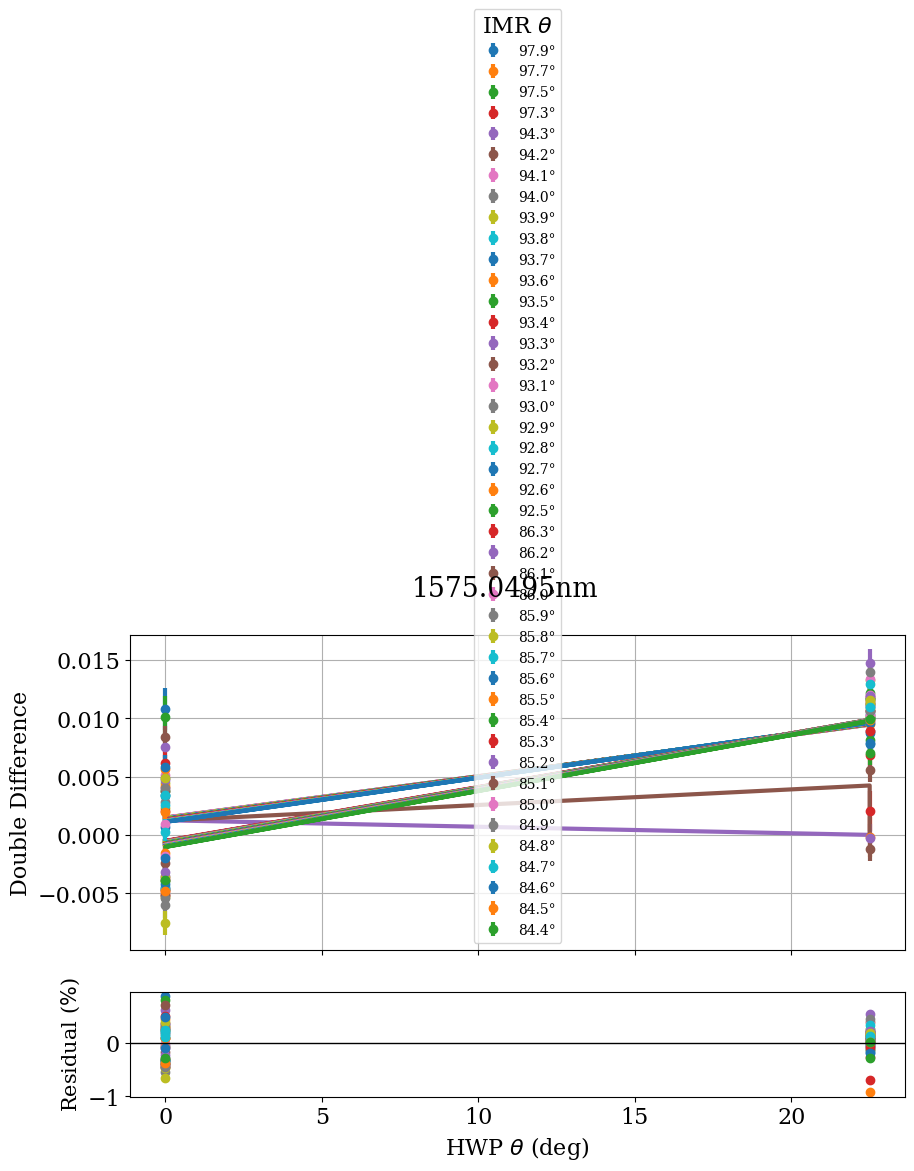

Updated Mueller Matrix:
[[ 5.57726724e-03 -5.32150360e-03  1.55052924e-03 -6.18687326e-04]
 [ 5.47659870e-04 -5.16507791e-04  1.75138777e-04 -5.54231304e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
424 212
Residuals range: -0.9161198205121037 0.8538485397861082
s_res: 0.31693894740750667


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 579.3488380980275
       x: [ 9.893e-01 -9.814e-02  1.082e-01  9.900e-01  2.757e+00]
     nit: 38
     jac: [-1.446e+03  5.818e+01 -1.223e+02 -3.052e-05 -2.777e+00]
    nfev: 341
    njev: 35
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 579.3486555688949
       x: [ 9.893e-01 -9.814e-02  1.082e-01  9.900e-01  2.757e+00]
     nit: 1
     jac: [-1.446e+03  5.818e+01 -1.223e+02 -3.052e-05 -2.777e+00]
    nfev: 14
    njev: 1


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


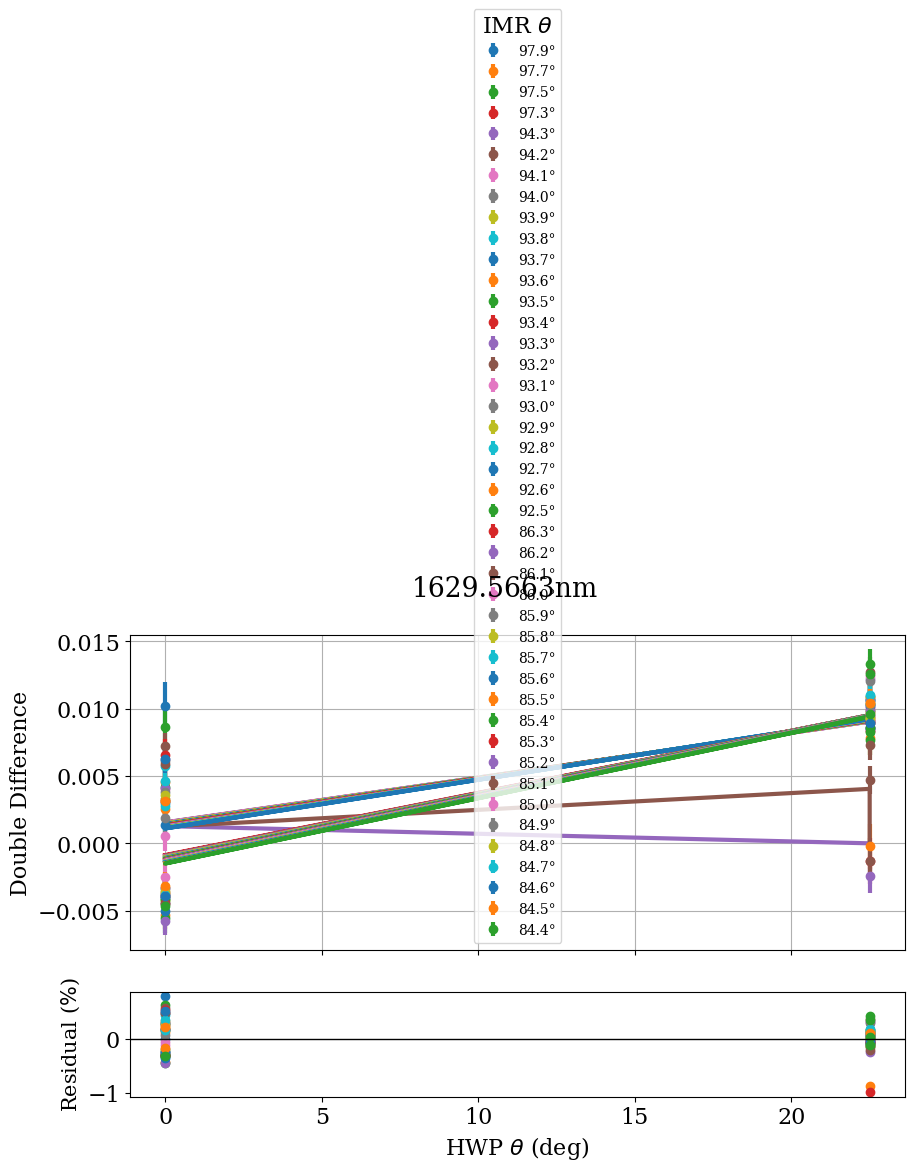

Updated Mueller Matrix:
[[ 6.67995760e-03 -6.47181999e-03  1.57652560e-03 -5.01801609e-04]
 [ 8.30236487e-04 -8.01481148e-04  2.07281628e-04 -6.40054320e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
424 212
Residuals range: -0.9832721622859064 0.7740235585345172
s_res: 0.2907140697771057


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 546.80683189541
       x: [ 9.858e-01 -1.281e-01  1.084e-01  9.979e-01  6.188e+00]
     nit: 53
     jac: [-1.025e+04  1.306e+03 -1.097e+03  7.629e-06 -1.892e-01]
    nfev: 423
    njev: 49
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 546.8056424518826
       x: [ 9.858e-01 -1.281e-01  1.084e-01  9.979e-01  6.188e+00]
     nit: 1
     jac: [-1.025e+04  1.306e+03 -1.097e+03  7.629e-06 -1.892e-01]
    nfev: 14
    njev: 1


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


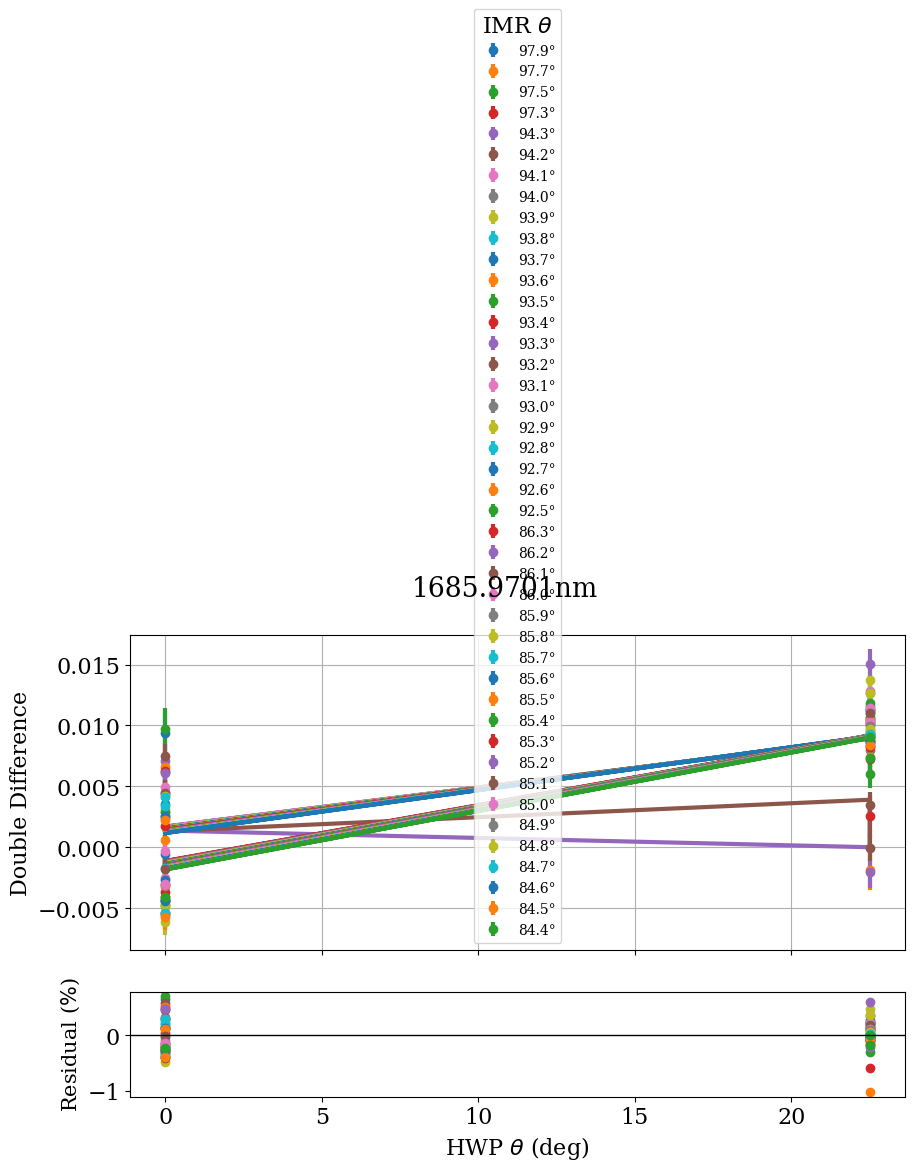

Updated Mueller Matrix:
[[ 0.00819032 -0.00796693  0.0014914  -0.00117641]
 [-0.00147301  0.00143667 -0.00023811  0.00022395]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
424 212
Residuals range: -1.0205798123092542 0.7029601908112058
s_res: 0.28971744858779663


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 521.5631231924551
       x: [ 9.875e-01 -1.179e-01  1.051e-01  9.883e-01  7.862e+00]
     nit: 30
     jac: [-3.040e+02  5.559e+01  9.998e+00  2.289e-05  6.740e-01]
    nfev: 235
    njev: 29
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 521.563087254357
       x: [ 9.875e-01 -1.179e-01  1.051e-01  9.883e-01  7.862e+00]
     nit: 1
     jac: [-3.258e+02  5.813e+01  7.771e+00  7.629e-06  6.743e-01]
    nfev: 14
    njev: 1


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


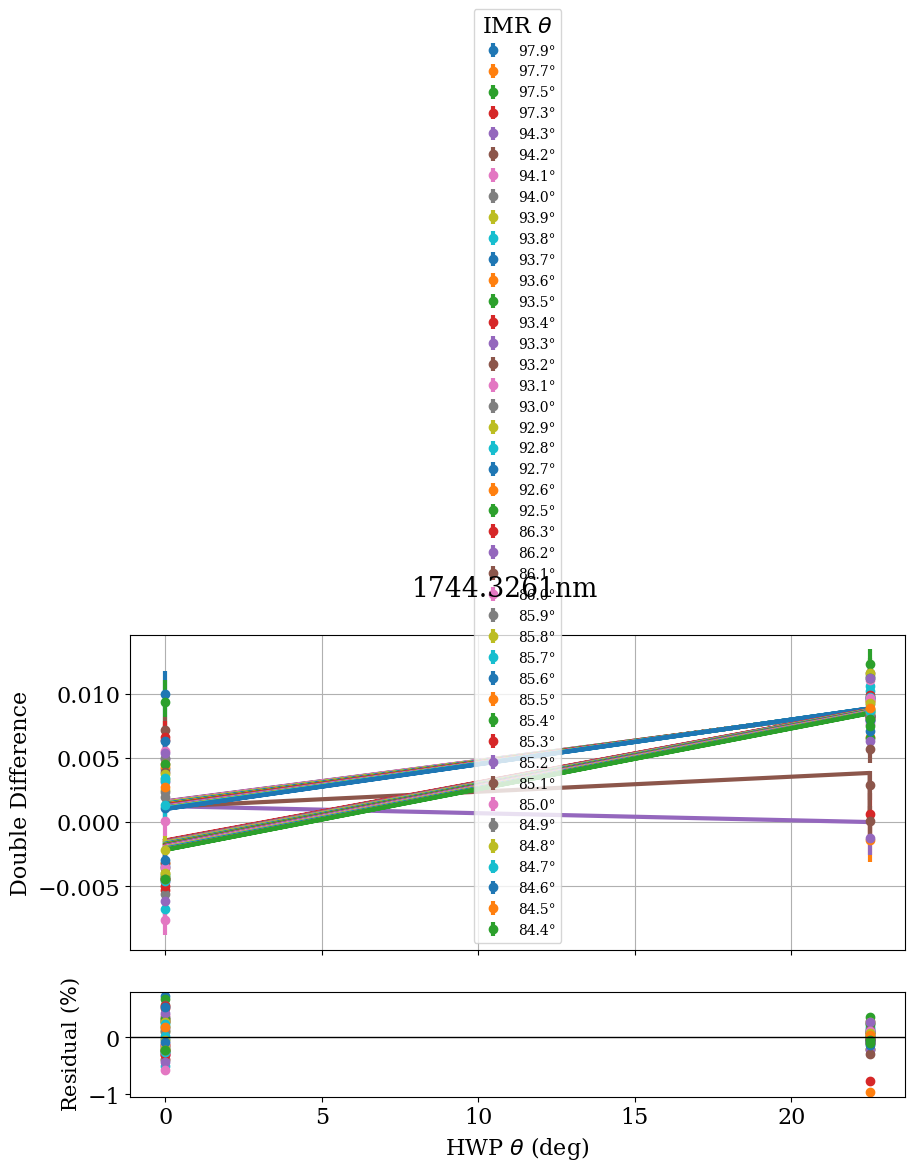

Updated Mueller Matrix:
[[ 0.01125563 -0.01094811  0.00144491 -0.00217686]
 [-0.00619645  0.00602742 -0.00076744  0.00121608]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
424 212
Residuals range: -0.9612789147755569 0.7123445278890446
s_res: 0.27860224622098767


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 793.300757506989
       x: [ 9.946e-01 -6.376e-02  8.218e-02  9.881e-01  2.391e+00]
     nit: 32
     jac: [-6.027e+03  2.648e+02 -6.019e+02  1.755e-04 -4.203e+00]
    nfev: 268
    njev: 29
 message: Singular matrix E in LSQ subproblem
 success: False
  status: 5
     fun: 793.2674089310362
       x: [ 9.946e-01 -6.376e-02  8.218e-02  9.881e-01  2.391e+00]
     nit: 8
     jac: [       nan  6.357e+03 -8.929e+03 -7.629e-06 -4.206e+00]
    nfev: 68
    njev: 6


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


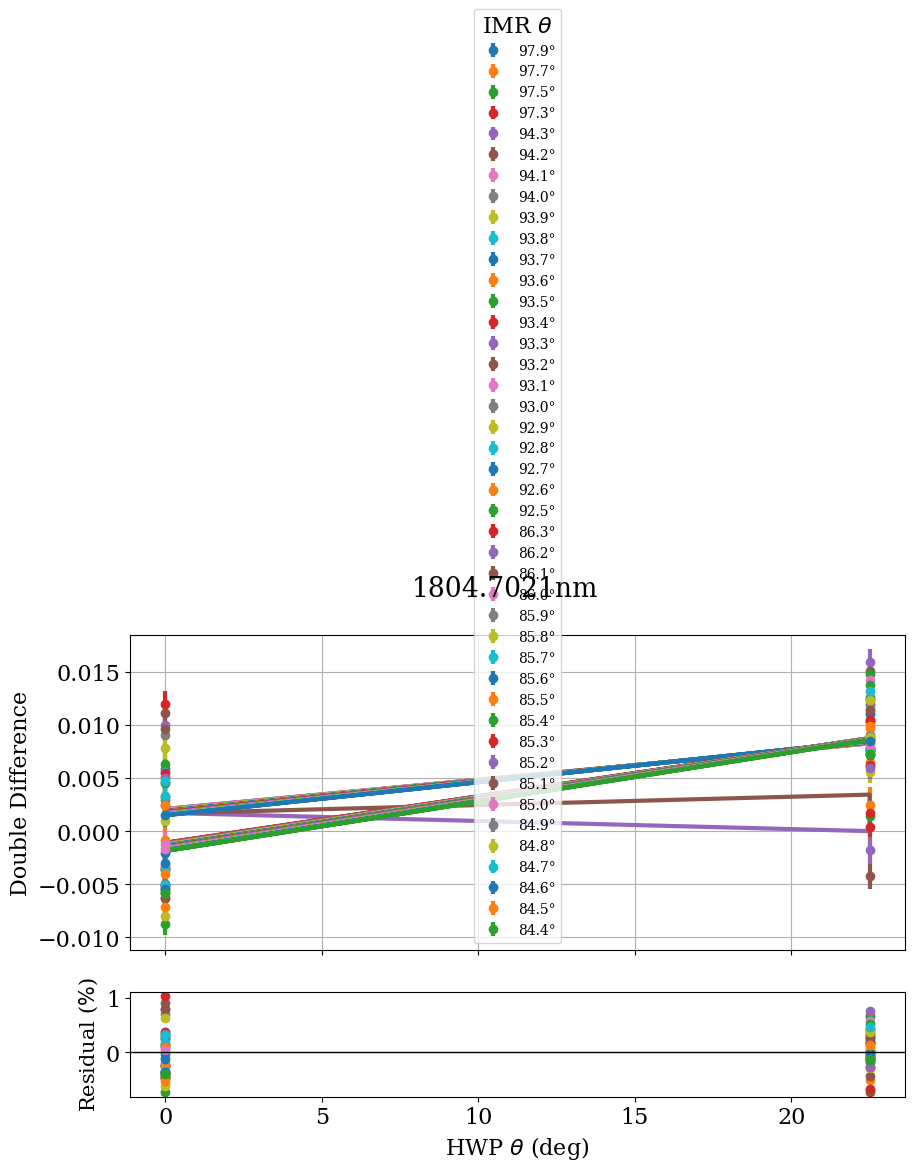

Updated Mueller Matrix:
[[ 4.84771254e-03 -4.74942096e-03  9.07707570e-04 -3.45433794e-04]
 [ 1.29973356e-03 -1.27190099e-03  2.50454728e-04 -9.43793102e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
424 212
Residuals range: -0.7274091990700818 1.0241086610452825
s_res: 0.3847945152144491


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 645.3565414310073
       x: [ 9.947e-01 -7.024e-02  7.555e-02  9.854e-01  6.521e+00]
     nit: 32
     jac: [-3.372e+03  2.511e+02 -2.162e+02  1.526e-05  9.558e-01]
    nfev: 270
    njev: 29
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 645.3565082604284
       x: [ 9.947e-01 -7.024e-02  7.555e-02  9.854e-01  6.521e+00]
     nit: 1
     jac: [-3.664e+03  2.678e+02 -2.346e+02 -9.918e-05  9.559e-01]
    nfev: 15
    njev: 1


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


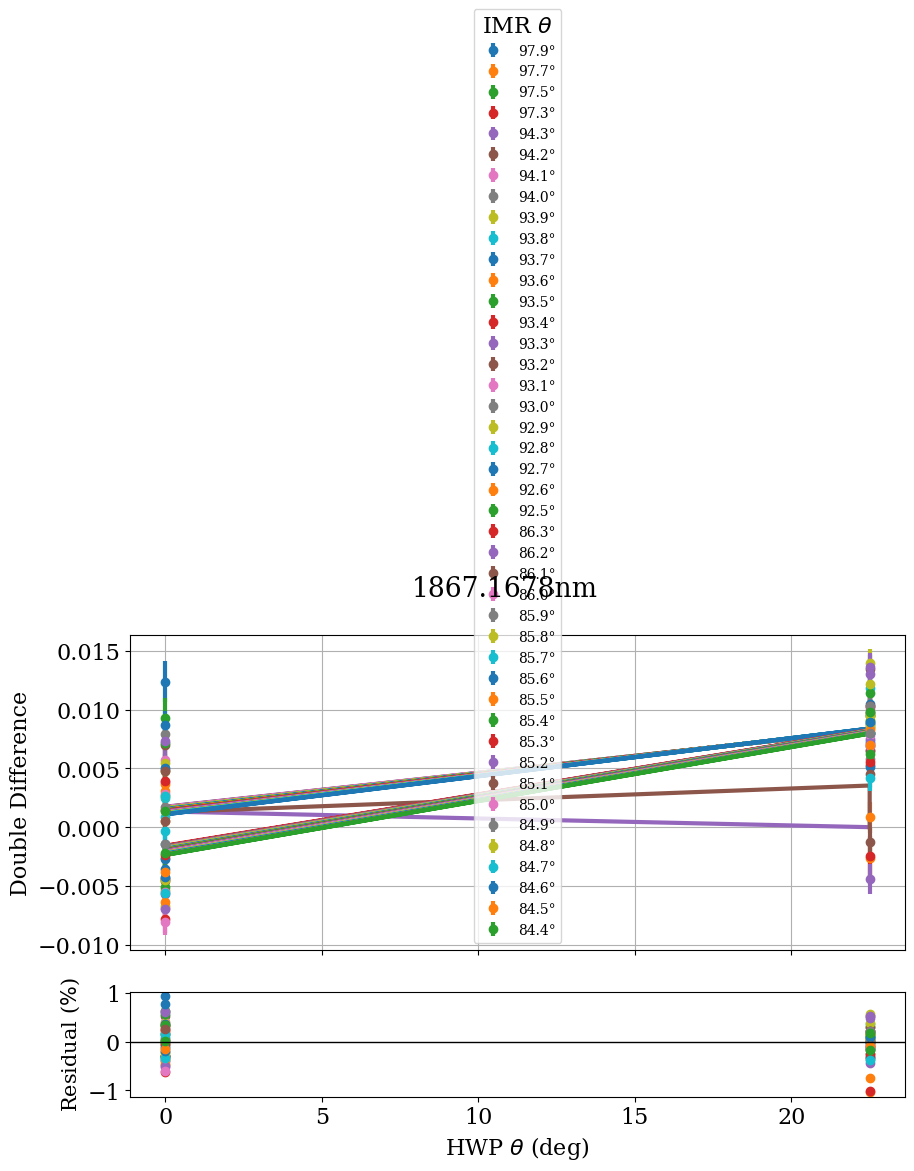

Updated Mueller Matrix:
[[ 0.01051174 -0.0102648   0.00111991 -0.00196877]
 [-0.00448282  0.00437741 -0.0004645   0.00084766]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
424 212
Residuals range: -1.033436365008893 0.9266892833596956
s_res: 0.35373047510616257


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Singular matrix E in LSQ subproblem
 success: False
  status: 5
     fun: 480.3799346744786
       x: [ 9.897e-01 -1.057e-01  9.646e-02  9.907e-01  5.596e+00]
     nit: 56
     jac: [       nan  8.048e+01 -3.329e+01  1.526e-05  5.100e-01]
    nfev: 460
    njev: 56
 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 480.3799346744786
       x: [ 9.897e-01 -1.057e-01  9.646e-02  9.907e-01  5.596e+00]
     nit: 1
     jac: [       nan  8.048e+01 -3.329e+01  1.526e-05  5.100e-01]
    nfev: 6
    njev: 1


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


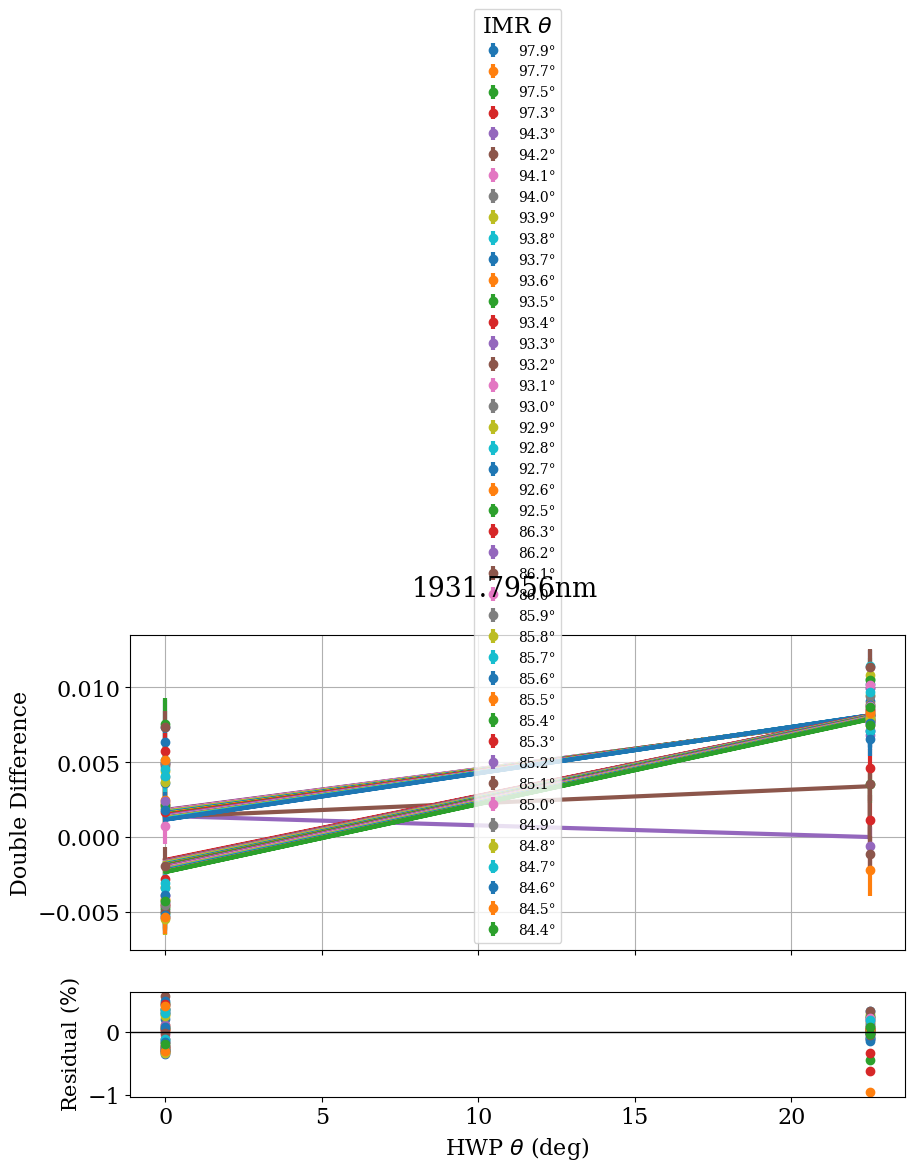

Updated Mueller Matrix:
[[ 7.82377100e-03 -7.70730803e-03  9.31576527e-04 -9.69993341e-04]
 [-7.29645492e-04  7.19638628e-04 -7.84779338e-05  9.17474958e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
424 212
Residuals range: -0.9550840396233728 0.5552509037293246
s_res: 0.2485640786016656


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 448.79339473217186
       x: [ 9.934e-01 -7.920e-02  8.309e-02  9.914e-01  5.702e+00]
     nit: 32
     jac: [-1.445e+04  9.745e+02 -1.024e+03 -7.629e-06  5.962e-01]
    nfev: 267
    njev: 29
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 448.79322281105226
       x: [ 9.934e-01 -7.920e-02  8.309e-02  9.914e-01  5.702e+00]
     nit: 1
     jac: [-2.195e+04  1.211e+03 -1.294e+03 -4.959e-05  5.965e-01]
    nfev: 15
    njev: 1


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


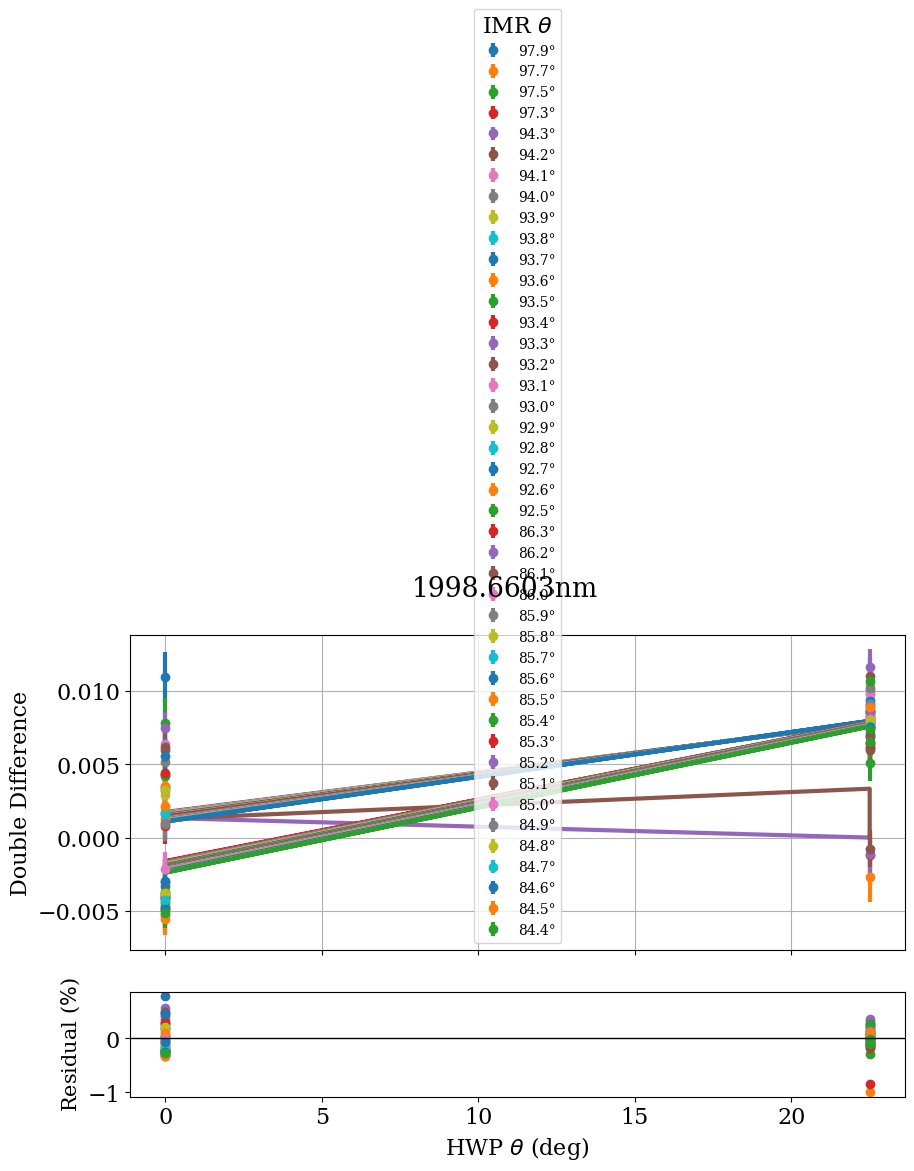

Updated Mueller Matrix:
[[ 0.00774581 -0.00759298  0.0008246  -0.00129006]
 [-0.00278171  0.00272708 -0.00029066  0.0004653 ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
424 212
Residuals range: -0.9913660682591409 0.7790418989052128
s_res: 0.25758940656742924


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 412.4490894481594
       x: [ 9.909e-01 -9.180e-02  9.890e-02  9.902e-01  4.716e+00]
     nit: 41
     jac: [-4.603e+02  5.203e+01 -2.552e+01 -6.104e-05  3.345e-01]
    nfev: 352
    njev: 37
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 412.4490426505214
       x: [ 9.909e-01 -9.180e-02  9.890e-02  9.902e-01  4.716e+00]
     nit: 1
     jac: [-4.603e+02  5.203e+01 -2.552e+01 -6.104e-05  3.345e-01]
    nfev: 14
    njev: 1


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


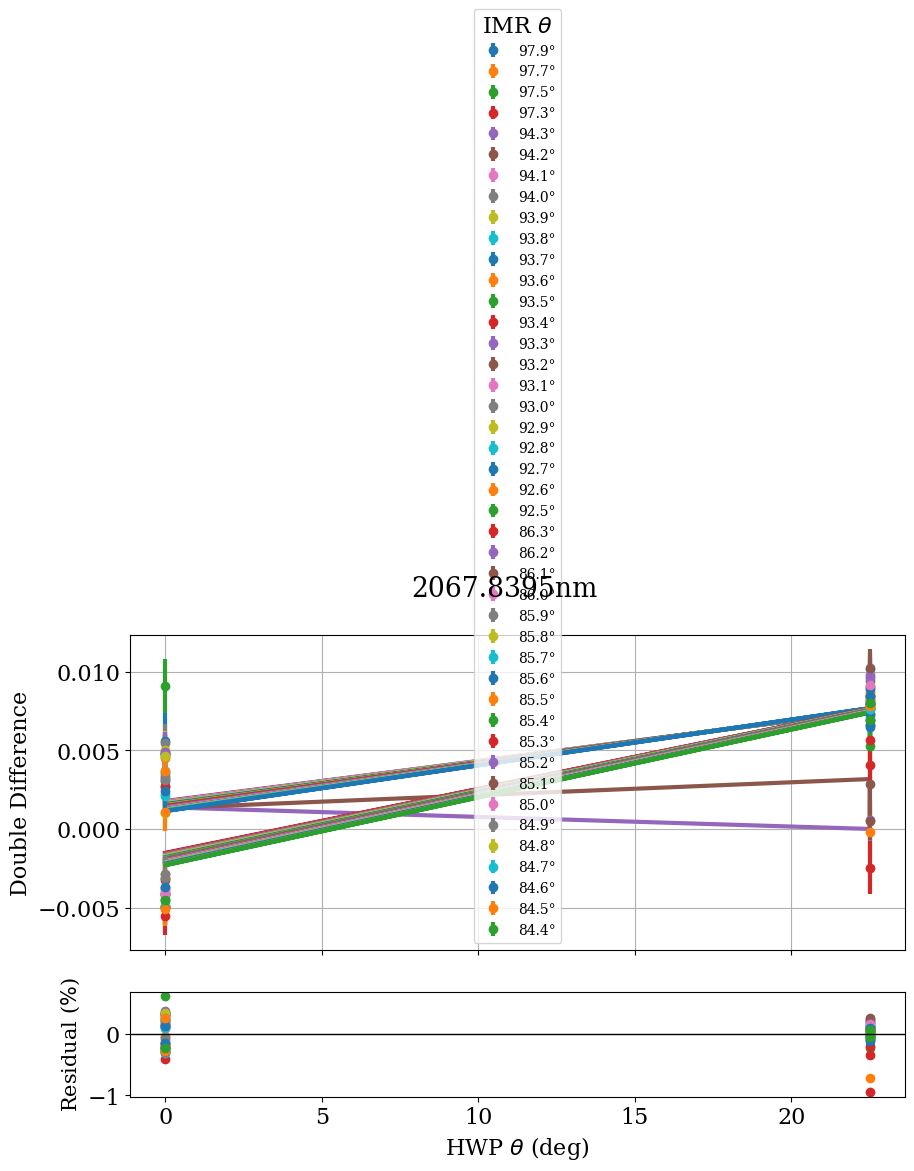

Updated Mueller Matrix:
[[ 0.00856579 -0.00843239  0.00096322 -0.00115567]
 [ 0.00112362 -0.00109908  0.00019046 -0.00015   ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
424 212
Residuals range: -0.9449482188303613 0.6088919080259547
s_res: 0.22901012028152531


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 387.9507069088729
       x: [ 9.915e-01 -8.709e-02  9.635e-02  9.903e-01  5.426e+00]
     nit: 34
     jac: [-2.024e+03  1.807e+02 -2.047e+02  7.629e-06  1.124e-01]
    nfev: 263
    njev: 30
 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 387.9403013718007
       x: [ 9.915e-01 -8.709e-02  9.636e-02  9.903e-01  5.426e+00]
     nit: 16
     jac: [-2.523e+04  1.812e+03 -2.063e+03  0.000e+00  1.252e-01]
    nfev: 147
    njev: 12


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


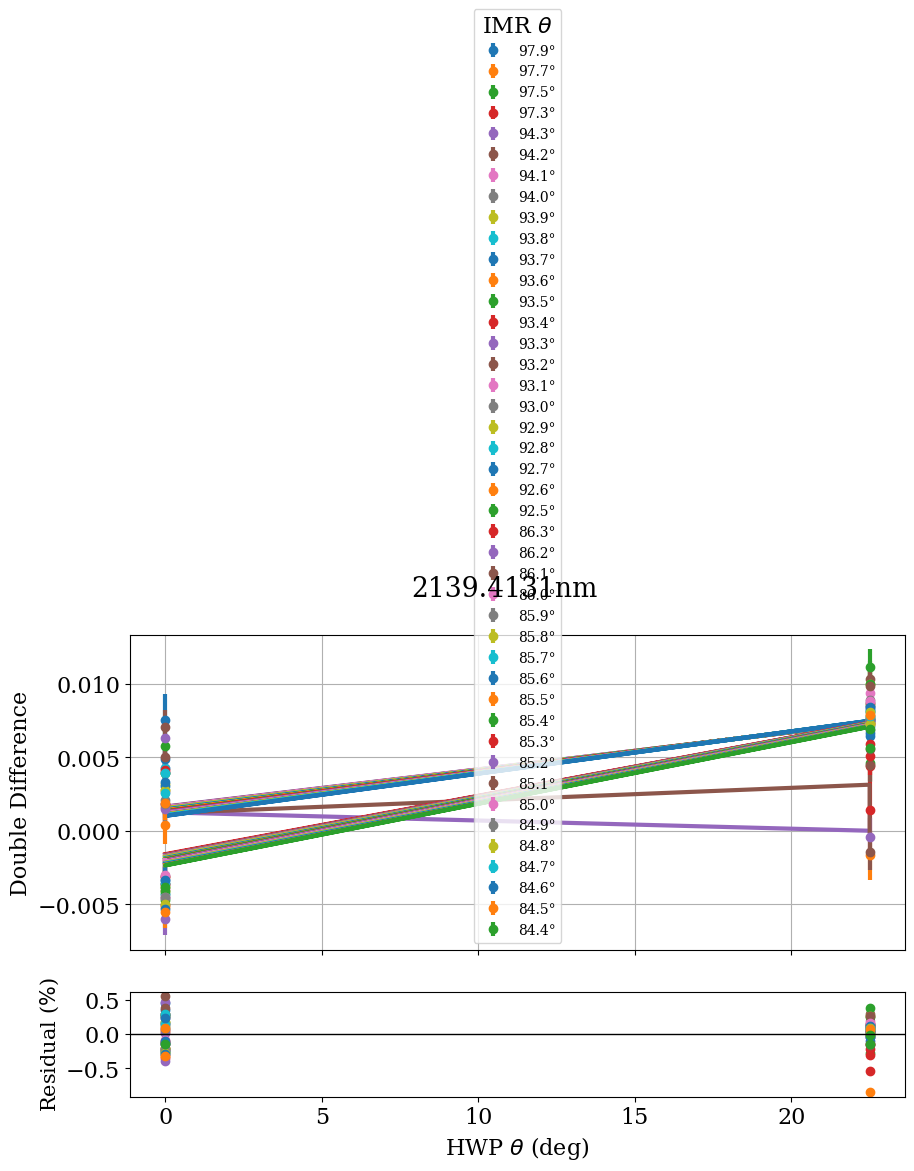

Updated Mueller Matrix:
[[ 9.69525815e-03 -9.47900738e-03  1.02382159e-03 -1.76011220e-03]
 [-3.82829025e-05  3.84548086e-05  1.11878424e-05  1.02854594e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
424 212
Residuals range: -0.8470895258312375 0.5466718944444309
s_res: 0.22538374172685585


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Singular matrix E in LSQ subproblem
 success: False
  status: 5
     fun: 364.90621511142655
       x: [ 9.891e-01 -9.890e-02  1.089e-01  9.956e-01  4.661e+00]
     nit: 38
     jac: [       nan -2.451e+00  3.376e+01  3.433e-05  4.346e-01]
    nfev: 295
    njev: 38
 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 364.90621511142655
       x: [ 9.891e-01 -9.890e-02  1.089e-01  9.956e-01  4.661e+00]
     nit: 1
     jac: [       nan -2.451e+00  3.376e+01  3.433e-05  4.346e-01]
    nfev: 6
    njev: 1


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


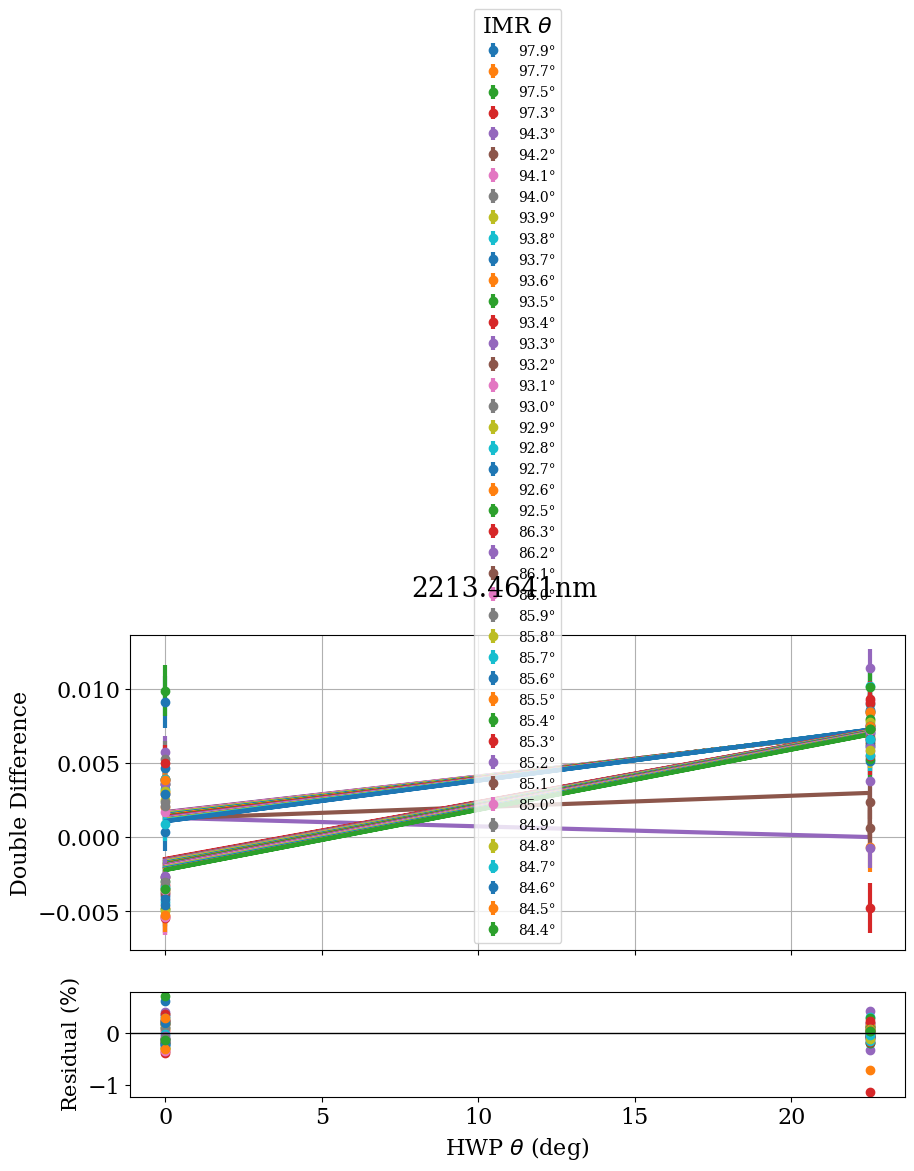

Updated Mueller Matrix:
[[ 0.01161863 -0.01136652  0.00142625 -0.00193919]
 [ 0.00373742 -0.00365454  0.00047242 -0.00062423]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
424 212
Residuals range: -1.140041308973926 0.7015899535035556
s_res: 0.24512490053151248


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 352.34415968298686
       x: [ 9.807e-01 -1.282e-01  1.475e-01  9.895e-01  4.216e+00]
     nit: 37
     jac: [-3.429e+03  4.174e+02 -5.226e+02 -5.341e-05 -1.019e+00]
    nfev: 288
    njev: 33
 message: Singular matrix E in LSQ subproblem
 success: False
  status: 5
     fun: 352.33214038242124
       x: [ 9.807e-01 -1.282e-01  1.475e-01  9.895e-01  4.216e+00]
     nit: 22
     jac: [       nan  6.690e+03 -8.979e+03  7.629e-06 -1.012e+00]
    nfev: 236
    njev: 18


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


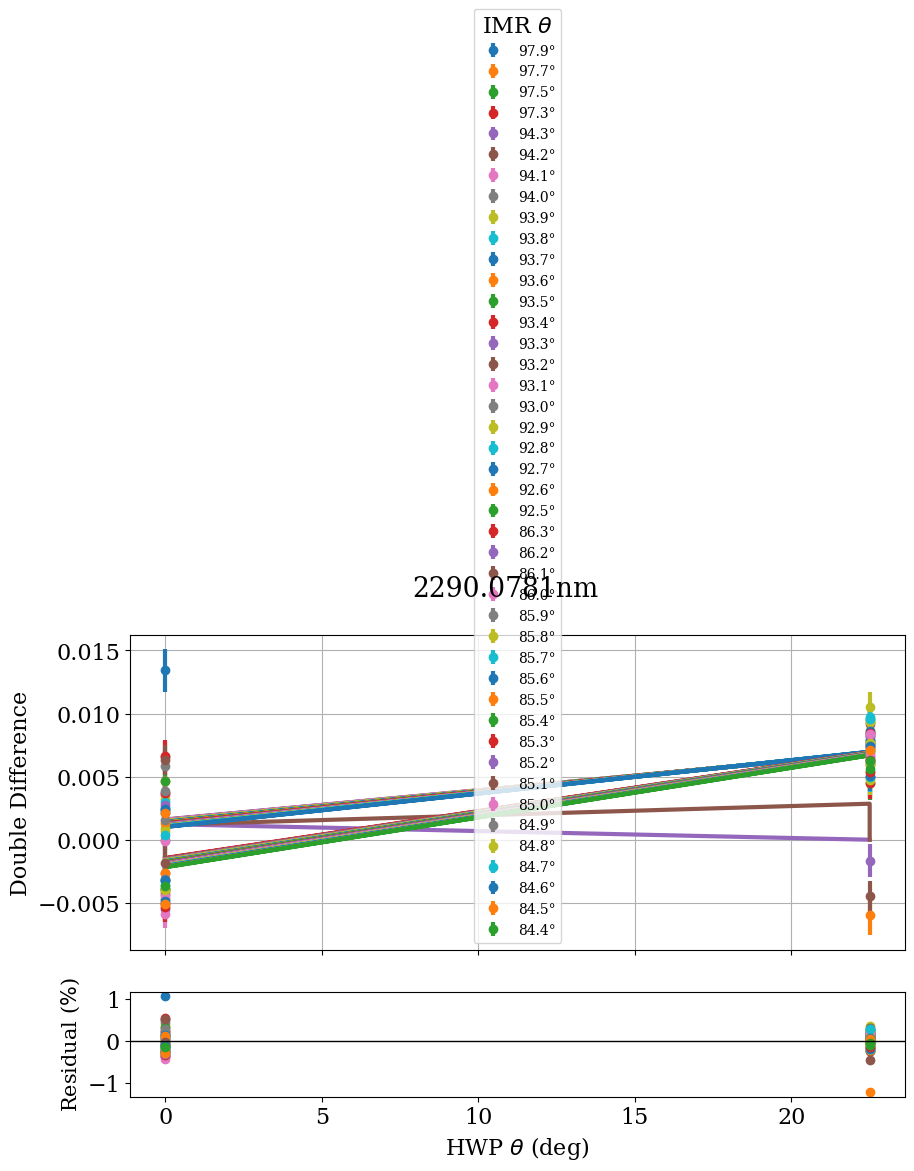

Updated Mueller Matrix:
[[ 0.0148851  -0.01461686  0.00182308 -0.0021424 ]
 [ 0.00394732 -0.00387431  0.00049349 -0.0005724 ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
424 212
Residuals range: -1.2227209466878497 1.0589599585505571
s_res: 0.26709139338283455


/opt/anaconda3/envs/charisenv/lib/python3.9/site-packages/pyMuellerMat/common_mm_functions.py:137: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(1 - d**2)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 588.2963117317231
       x: [ 9.906e-01 -9.179e-02  1.011e-01  9.867e-01  5.225e+00]
     nit: 23
     jac: [-1.287e+03  1.528e+02 -1.044e+02 -7.629e-06  1.186e+00]
    nfev: 197
    njev: 21
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 588.2961641098819
       x: [ 9.906e-01 -9.179e-02  1.011e-01  9.867e-01  5.225e+00]
     nit: 1
     jac: [-1.402e+03  1.633e+02 -1.159e+02  2.289e-05  1.187e+00]
    nfev: 14
    njev: 1


/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/plotting.py:166: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle


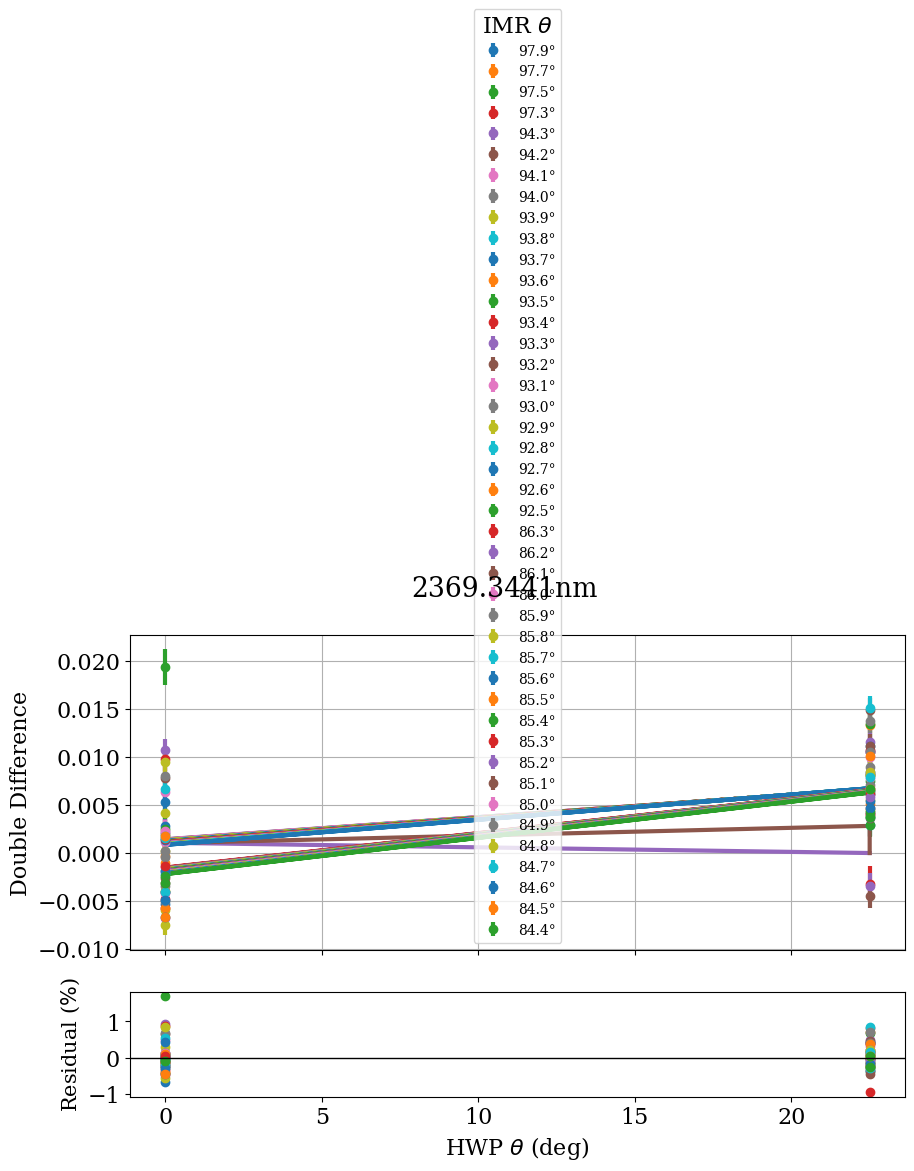

Updated Mueller Matrix:
[[ 0.02098539 -0.02027359  0.00243168 -0.00484166]
 [ 0.01204549 -0.01163225  0.00148708 -0.00275435]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
424 212
Residuals range: -0.9424686803342734 1.6863091455045023
s_res: 0.40054885200563095


In [6]:
# fit all wavelength bins
errors = []
sres_list = []
for bin in range (0,22):
    filepath = Path(f'datacsvs/onsky_csvs/unpol_standards/bin{bin}.csv')


    fig2, ax2,sres = fit_CHARIS_Mueller_matrix_by_bin_m3(filepath, bin, 
        Path(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/unpol_imr_diat_fit/bin{bin}.json'),
    )
    #errors.append(error)
    sres_list.append(sres)




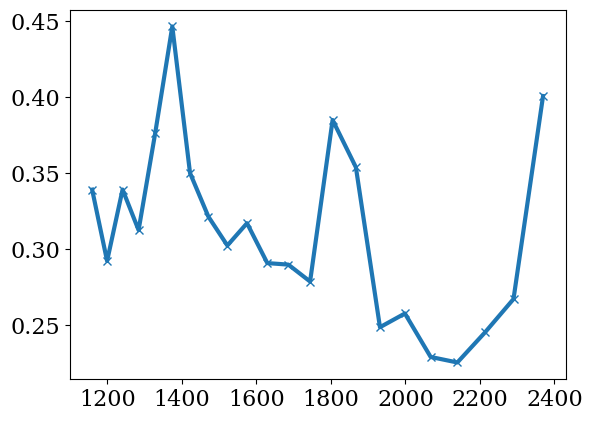

In [7]:
from matplotlib import pyplot as plt
plt.plot(wavelength_bins, sres_list, marker='x')

In [17]:
# visualize errors
errors=np.array(errors)
errors1 = np.mean(errors[:,0])
errors2 = np.mean(errors[:,1])
errors3 = np.mean(errors[:,2])
print(errors1,errors2,errors3)

2.552143618341572 0.513877145527641 48.11189100584634


In [64]:
# grab a df of all the fits
from vampires_calibration.plotting import model_data
jsondir = Path('/home/thomasmc/charis_mm_testing/m3-fit/sys_dicts')
df = model_data(jsondir)
df


,wavelength_bin,eps
0,1159.5614,0.014444
1,1199.6971,0.013618
2,1241.2219,0.013725
3,1284.1840,0.013057
4,1328.6331,0.012795
5,1374.6208,0.012158
6,1422.2002,0.012283
7,1471.4264,0.011390
8,1522.3565,0.010867
9,1575.0495,0.011042


In [65]:
# refine model
def phys_model_chisq(p0, wavelengths, diat_m3,errors_m3):
    """
    Calculate the chi squared for the physical model of CHARIS.
    
    Parameters:
    -----------
    p0 : list
        List of parameters [m1,b1,m2,b2].
    
    wavelengths : numpy array
        Array of wavelengths that are in the data.

    diat_m3 : float
        Diattenuation of the M3 mirror at the given wavelengths.
    
    errors_m3 : numpy array
        Array of errors for the M3 diattenuation.

    Returns:
    --------
    float
        The chi squared value.
    """
    # Get model diat
    model_diat = M3_diattenuation(wavelengths, p0[0],p0[1],p0[2],p0[3])

    # Calculate residual

    residuals_m3 = (model_diat - diat_m3) / errors_m3

    # Calculate chisq
    chisq_m3 = np.sum(residuals_m3**2)
    return chisq_m3


In [66]:
# refine model
def phys_model_cost(p0, wavelengths, diat_m3,errors_m3):
    """
    Calculate the chi squared for the physical model of CHARIS.
    
    Parameters:
    -----------
    p0 : list
        List of parameters [m1,b1,m2,b2].
    
    wavelengths : numpy array
        Array of wavelengths that are in the data.

    diat_m3 : float
        Diattenuation of the M3 mirror at the given wavelengths.
    
    errors_m3 : numpy array
        Array of errors for the M3 diattenuation.

    Returns:
    --------
    float
        The cost value.
    """
    # Get model diat
    model_diat = M3_diattenuation(wavelengths, p0[0],p0[1],p0[2],p0[3])

    # Ensure all inputs are 1D arrays
    model_diat = model_diat.ravel()
    diat_m3 = diat_m3.ravel()
    errors_m3 = errors_m3.ravel()
    
    # Calculate residual

    cost = (model_diat - diat_m3) / errors_m3


    return cost


In [68]:
from scipy.optimize import minimize
from vampires_calibration.fitting import update_p0
# define bounds
p0 = [2.104,14.2,2.1,13.2]
m1_b = (0.8*p0[0],1.2*p0[0])
b1_b = (0.8*p0[1],1.2*p0[1])
m2_b = (0.8*p0[2],1.2*p0[2])    
b2_b = (0.8*p0[3],1.2*p0[3])
m3_diat = df['eps'].values
bounds = [m1_b, b1_b, m2_b, b2_b]

# iterative fitting
iteration = 1
previous_chisq = 1000000
new_chisq = 0

while abs(previous_chisq-new_chisq)> 0.01*abs(previous_chisq):
        previous_chisq = new_chisq
        result = minimize(phys_model_chisq,p0, args=(wavelength_bins,m3_diat,errors), bounds=bounds)
        p0 = result.x
        new_chisq = result.fun
        iteration += 1
        print(result)

# get error from covariance matrix
covariance_matrix = result.hess_inv.todense()
errors_phys = np.sqrt(np.diag(covariance_matrix))
print("Final Parameters:")
print(p0)
print("Final Errors:")
print(errors_phys)





  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 524.6037228172947
        x: [ 1.752e+00  1.327e+01  1.752e+00  1.399e+01]
      nit: 524
      jac: [-2.012e+01  3.458e+00 -5.697e+01  9.834e+00]
     nfev: 3735
     njev: 747
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 524.6036816264085
        x: [ 1.752e+00  1.327e+01  1.752e+00  1.399e+01]
      nit: 2
      jac: [-5.101e-01  7.551e-02  1.022e-01 -5.208e-02]
     nfev: 35
     njev: 7
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
Final Parameters:
[ 1.75195754 13.27005348  1.75230696 13.99430485]
Final Errors:
[0.9602864  1.50372171 0.58393726 2.19512422]


[ 1.75195754 13.27005348  1.75230696 13.99430485]


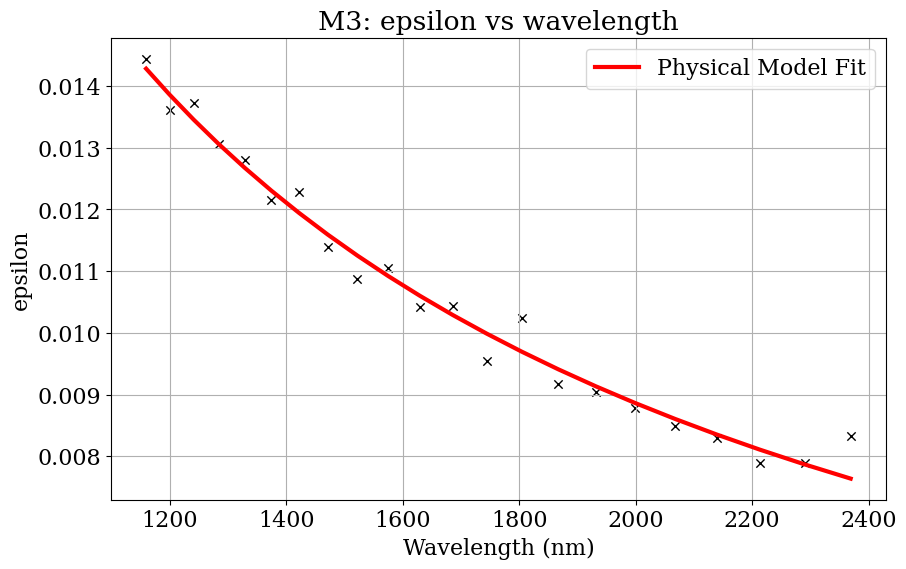

In [28]:
from vampires_calibration.plotting import plot_config_dict_vs_wavelength
params, fig,ax = plot_config_dict_vs_wavelength('M3','epsilon',jsondir)
print(p0)
ax.plot(wavelength_bins, M3_diattenuation(wavelength_bins,p0[0],p0[1],p0[2],p0[3]), label='Physical Model Fit', color='red')
ax.legend()